In [4]:
import pandas as pd
import os
import numpy as np
import requests
import json
from string import Template
import random
import time
from math import floor
import matplotlib.pyplot as plt
import seaborn as sns
#不支持中文的解决办法
plt.rcParams['font.sans-serif']=['Arial Unicode MS'] #用来正常显示中文标签

In [37]:
class FundBT():
    def __init__(self, fundsList, loseStatusAssignFundCode, eachAdditionalCaptital: int, onRebalance: bool = True,inititalCaptital: int = 0, rebalanceRate: float = 0.05, startDate: str = "2018-01-01", endDate: str = "2023-12-01"):
        self.totalCaptital = 0
        self.totalAdditionalCaptital = 0
        self.totalFee = 0
        self.inititalCaptital = inititalCaptital
        self.eachAdditionalCaptital = eachAdditionalCaptital
        self.startDate = startDate
        self.endDate = endDate
        self.maxDrawdown = 0
        self.rebalanceRate = rebalanceRate
        self.onRebalance = onRebalance

        self.rebalanceCaptitalPool = 0


        # 记录缺失数据的基金，用于计算初始资金的时候跳过
        self.ignore_funds = []
        # 记录缺失数据的基金，将其比例汇总，后期归到_loseStatusAssignFundCode基金的比例中
        self.ignore_funds_rate = 0

        # 用于控制当前计算的日期
        self._currentDate = 0

        # 记录最大的时间，如果超过则代表计算结束
        self._maxDate = 0

        # 当其他基金是后期加入或者在定投日没有数据的时候，将会把没有数据的基金份额增加到该基金上去
        # 该基金时间范围必须为最长。
        self._loseStatusAssignFundCode = loseStatusAssignFundCode

        # 最后一个交易日
        self._last_exchange_day = 1

        # 初始化基础数据和格式
        self.fundsList = {}

        # 用于计算整个资金情况
        self.totalCaptitalData = None

        # 已购买基金，列表形式，避免因为基金本身的特殊原因，比如境外、暂停等原因导致没有数据造成计算错误
        self.purchasedFunds = set()

        for fund in fundsList:
            fundFormat = {
                "name": fund["name"],
                "code": fund["code"],
                "maxDrawdown": 0,
                "rate": fund["rate"],
                "purchaseFee": fund["purchaseFee"],
                "sellFee": fund["sellFee"],
                "lastMonth": 0, # 用于控制当前基金是否要定投
                "data": None
            }
            self.fundsList[fund["code"]] = fundFormat

    def getFundData(self, code):

        page = 1

        resultData = None
        
        # 设置请求头
        headers = {} # 需要设置
        url_Template = Template("") # 需要设置

        while True:

            url = url_Template.substitute(code=code, page=page, startDate=self.startDate, endDate=self.endDate)
        
            response = requests.get(url, headers= headers)

            data = json.loads(response.text[response.text.find("(") + 1 : response.text.rfind(")")])["Data"]["LSJZList"]

            # 如果检查到没有数据返回则完成数据获取
            if len(data) == 0:
                break

            # 检查返回的数据是不是为空，为空则赋值，不为空则拼接
            
            if resultData is None:
                resultData = pd.DataFrame(data)
            else:
                resultData = pd.concat([resultData, pd.DataFrame(data)])

            page = page + 1

            # 随机休眠0-9秒
            sleep_time = random.uniform(0,9)   #随机一个大于0小于9的小数
            time.sleep(sleep_time)

        return resultData
        
    def checkFundData(self):
        willGetDataFundList = [] # 存放没有本地数据，需要网络获取的数据
        baseDir = './data/'
        
        for code in self.fundsList.keys():
            code = self.fundsList[code]["code"]
            data = None
            filenameXLSX = baseDir + code + '-' + self.startDate + '-' + self.endDate + '.xlsx'
            filenameCSV = baseDir + code + '-' + self.startDate + '-' + self.endDate + '.csv'

            # 根据类型进行读取数据
            if os.path.exists(filenameXLSX):
                data = pd.read_excel(filenameXLSX)
            elif os.path.exists(filenameCSV):
                data = pd.read_csv(filenameCSV)
            else:
                # 如果不存在，则把当前循环的基金代码存入待获取列表中，并且跳过当前循环
                willGetDataFundList.append(code)
                continue


            
            self.fundsList[code]["data"] = data[["FSRQ", "DWJZ"]].copy(deep=True)

            # 显性转换类型
            self.fundsList[code]["data"]["FSRQ"] = pd.to_datetime(self.fundsList[code]["data"]["FSRQ"])
            self.fundsList[code]["data"]["DWJZ"] = pd.to_numeric(self.fundsList[code]["data"]["DWJZ"])

            self.fundsList[code]["data"]["captital"] = 0.0
            self.fundsList[code]["data"]["share"] = 0.0
            self.fundsList[code]["data"]["Drawdown"] = 0.0
            self.fundsList[code]["data"]["purchaseFee"] = 0.0
            self.fundsList[code]["data"]["sellFee"] = 0.0
            self.fundsList[code]["data"]["additionalCaptital"] = 0.0
            self.fundsList[code]["data"]["rebalance"] = 0.0

            # 按时间排序，从小到大
            # self.fundsList[fundCodeKey]["data"].sort_values(by="FSRQ", inplace=True)


        # 开始获取新数据
        for code in willGetDataFundList:
            
            data = self.getFundData(code)

            # 将获取的数据写入本地
            data.to_excel(baseDir + code + '-' + self.startDate + '-' + self.endDate + '.xlsx')

            # 将获取的数据传递给基金
            self.fundsList[code]["data"] = data[["FSRQ", "DWJZ"]].copy(deep=True)

            # 显性转换类型
            self.fundsList[code]["data"]["FSRQ"] = pd.to_datetime(self.fundsList[code]["data"]["FSRQ"])
            self.fundsList[code]["data"]["DWJZ"] = pd.to_numeric(self.fundsList[code]["data"]["DWJZ"])

            self.fundsList[code]["data"]["captital"] = 0.0
            self.fundsList[code]["data"]["share"] = 0.0
            self.fundsList[code]["data"]["Drawdown"] = 0.0
            self.fundsList[code]["data"]["purchaseFee"] = 0.0
            self.fundsList[code]["data"]["sellFee"] = 0.0
            self.fundsList[code]["data"]["additionalCaptital"] = 0.0
            self.fundsList[code]["data"]["rebalance"] = 0.0


        # 数据排序，按照日期大小，并设置日期为索引
        for code in self.fundsList.keys():

            self.fundsList[code]["data"].sort_values(by='FSRQ', inplace=True)
            self.fundsList[code]["data"].set_index("FSRQ", inplace=True)


        # 生成总资金df表
        
        self.captitalData = pd.DataFrame(index= self.fundsList[self._loseStatusAssignFundCode]["data"].index, columns=['captital', 'drawdown'])
        self.captitalData.fillna(0.0, inplace=True)
        

    def outData(self):    

        _totalCaptital = 0.0
        _totalAddCaptital = 0.0
        _startDate = pd.to_datetime(self.startDate) + pd.Timedelta(days=1)
        # _lastDate = pd.to_datetime(self.endDate)  -  pd.Timedelta(days=1)
        _lastDate = pd.to_datetime(self.endDate) 
        _totalSellFee = 0.0
        _totalPurchaseFee = 0.0

        self.totalCaptitalData = pd.DataFrame(columns=['基金名字', '最早数据时间', '最晚数据时间', '总投入资金', '账户资金', '盈亏资金', '盈亏率', '最大回撤', '买入手续费合计', '卖出手续费合计'])
        
        for code in self.fundsList.keys():

            _currentFund = self.fundsList[code]

            _currentCaptital = _currentFund["data"].loc[_lastDate, 'captital']

            _totalCaptital +=  _currentCaptital
            _currentAddCaptital = _currentFund["data"]['additionalCaptital'].sum()
            _totalAddCaptital += _currentAddCaptital

            _currentSellFee = _currentFund["data"]['sellFee'].sum()
            _currentPurchaseFee = _currentFund["data"]['purchaseFee'].sum()

            _totalSellFee += _currentSellFee
            _totalPurchaseFee += _currentPurchaseFee


            # 计算最大回撤
            maxDWJZID = _currentFund['data']['DWJZ'].idxmax()
            maxDWJZ = _currentFund['data'].loc[maxDWJZID, 'DWJZ']
            minDWJZID = _currentFund['data']['DWJZ'].idxmin()
            minDWJZ = _currentFund['data'].loc[minDWJZID, 'DWJZ']
            startDWJZ = _currentFund['data'].iloc[0]['DWJZ']
            maxDrawdown = (maxDWJZ - minDWJZ) / maxDWJZ * 100


            data = {
                '基金名字': _currentFund['name'],
                '最早数据时间': _currentFund['data'].iloc[0].name.strftime('%Y-%m-%d'),
                '最晚数据时间': _currentFund['data'].loc[_lastDate].name.strftime('%Y-%m-%d'),
                '总投入资金': _currentAddCaptital,
                '账户资金': _currentCaptital,
                '盈亏资金': _currentCaptital - _currentAddCaptital,
                '盈亏率': ((_currentCaptital / _currentAddCaptital) - 1 ) * 100,
                '最大回撤': maxDrawdown,
                '买入手续费合计': _currentPurchaseFee,
                '卖出手续费合计': _currentSellFee
            }

            self.totalCaptitalData = pd.concat([self.totalCaptitalData, pd.DataFrame([data], index=[code])], ignore_index=True)
        
            
    #         print('''
    # 基金：{} ， 编码：{}， 最早数据时间：{}， 最晚数据时间：{}
    # 总投入资金：{}， 账户资金：{}， 盈亏资金：{}， 盈亏率：{}，最大回撤：{}
    # 买入手续费合计：{}，卖出手续费合计：{}
    #         '''.format(
    #             _currentFund['name'],
    #             _currentFund['code'],
    #             _currentFund['data'].iloc[0].name.strftime('%Y-%m-%d'),

                
    #             _currentFund['data'].loc[_lastDate].name.strftime('%Y-%m-%d'),
    #             _currentAddCaptital,
    #             _currentCaptital,
    #             _currentCaptital - _currentAddCaptital,
    #             ((_currentCaptital / _currentAddCaptital) - 1 ) * 100,
    #             maxDrawdown,
    #             _currentPurchaseFee,
    #             _currentSellFee
    #             )
    #         )

        print('''
    """""""""""""""""""""""""""""""""""""""""""""""""""
    所有资金汇总
    
    总投入资金：{}， 账户资金：{}， 盈亏资金：{}， 盈亏率：{}
    买入手续费合计：{}，卖出手续费合计：{}
    """""""""""""""""""""""""""""""""""""""""""""""""""
            '''.format(
                _totalAddCaptital,
                _totalCaptital,
                _totalCaptital - _totalAddCaptital,
                ((_totalCaptital / _totalAddCaptital) - 1 ) * 100,
                _totalPurchaseFee,
                _totalSellFee
                )
        )

        print(self.totalCaptitalData)

    def simulationsCalc(self):

        # 将_loseStatusAssignFundCode基金开始时间当作初始的时间指针，所以这里传递的基金一定是时间最长的
        self._currentDate = self.fundsList[self._loseStatusAssignFundCode]['data'].index[0]

        # 将_loseStatusAssignFundCode基金结束时间当作结束的时间指针，所以这里传递的基金一定是时间最长的
        self._maxDate = self.fundsList[self._loseStatusAssignFundCode]['data'].index[-1]

        while self._currentDate <= self._maxDate:

            # 每次日期变更则重制缺失的基金列表和缺失基金的比例
            self.ignore_funds = []
            self.ignore_funds_rate = 0

            
            # 开始循环当前日期的每个基金是否有不存在数据的，则将起比例添加到指定的基金中
            for code in self.fundsList.keys():
                
                _currentFund = self.fundsList[code]
    
    
                # 检查基金是不是有当前的时间，只有以下几种情况
                # 1. 基金还没有成立，则当作后续新增基金，则把配置好的比例增加到指定的基金中（传递进来的_loseStatusAssignFundCode）
                # 2. 都没有，则不是工作日
                if self._currentDate not in _currentFund["data"].index:
                    self.ignore_funds.append(code)
                    self.ignore_funds_rate += _currentFund["rate"]

            # 开始循环当前日期的每个基金
            for code in self.fundsList.keys():

                # 跳过当前日期没有数据的基金
                if code in self.ignore_funds:
                    continue
                
                _currentFund = self.fundsList[code]
        
                # 查找当前日期当前基金的上个工作日，避免周末和中国节假日没有交易数据导致的错误
                self._last_exchange_day = 1
                
                while ( self._currentDate - pd.Timedelta(days=self._last_exchange_day) ) not in _currentFund["data"].index :
        
                    
                    # 如果检查到基金第一条数据的日期和当前日期相等，则说明为新增基金，所以上一条的工作日等于第一条
                    if _currentFund["data"].iloc[0].name == self._currentDate:
                        self._last_exchange_day = 0
                        break
        
                    self._last_exchange_day += 1

                
                # 检查是不是第一次计算，如果为第一次计算则运行初始化资金方法
                if self._currentDate == self.fundsList[self._loseStatusAssignFundCode]['data'].index[0]:
    
                    self.calcInitCaptital(_currentFund= _currentFund)

                    # 记录下购买过的基金
                    self.purchasedFunds.add(code)

                    
                    # 更新定投状态
                    _currentFund['lastMonth'] = self._currentDate.month

                # 如果检查到上次记录的月份和当前的月份不一致的情况下，则开始处理每月资金定投
                elif self._currentDate.month != _currentFund['lastMonth']:
                    
                    self.calcAdditionalCaptital(_currentFund= _currentFund)

                    # 记录下购买过的基金
                    self.purchasedFunds.add(code)

                    # 更新定投状态
                    _currentFund['lastMonth'] = self._currentDate.month


                # 非上述两种情况，则只计算每日盈亏情况
                else:
                    self.calcIncome(_currentFund= _currentFund)


            # 再平衡检查，不管执行什么操作，再平衡都会进行检查，并且可能再定投、初始化后进行
            if self.onRebalance:
                self.calcRebalance()
 
            
            # 当前日期的所有基金计算执行完成后，将当前日期加1
            self._currentDate += pd.Timedelta(days=1)


    def calcRebalance(self):
        # 再平衡函数

        # 用于储存当前日期下的所有基金中的资金总和
        _totalCaptital = 0
        
        # 用于储存基金超过阈值，需要再平衡的基金
        _willRebalanceFunds = []
        _willPurchaseFunds = []

        # 单独获取需要调整的基金比例，避免已经购买了，但是当天没有数据而误算
        _willFundRateAdjust = 0.0

            

        # 计算出当前日期的总体资金情况，从已购买过的基金列表中循环，避免有些基金还没有开始
        for code in self.purchasedFunds:

            # 如果当前已申购的基金在当前日期不存在的列表当中，则跳过当前的再平衡，避免已购买基金当日没有数据造成整理数据出问题
            if code in self.ignore_funds:
                return False

            _currentFund = self.fundsList[code]

            _totalCaptital += _currentFund["data"].loc[self._currentDate, 'captital']

        # 循环原始基金列表
        for code_sub in self.fundsList:
            
            # 将原始基金列表中还没有购买的基金比例加入到指定基金中
            if code_sub not in self.purchasedFunds:
                
                _willFundRateAdjust += self.fundsList[code_sub]["rate"]


      # 计算目前基金占比情况，找到当前需要再平衡的基金存放至_willRebalanceFunds中
        for code in self.purchasedFunds:
            
            _currentFund = self.fundsList[code]
            _fundRate = _currentFund["rate"]

            if code == self._loseStatusAssignFundCode:
                _fundRateAdjust = _fundRate + _willFundRateAdjust
            else:
                _fundRateAdjust = _fundRate

            # 得到当前日期基金的占总体资金的比例
            _currentFundRate = _currentFund["data"].loc[self._currentDate, 'captital'] / _totalCaptital

            # 用实际比例减去调证的比例，如果为负数，则说明需要买入，如果为正数则说明要卖出
            _currentFundRateAdjustDiff = _currentFundRate - _fundRateAdjust

            # 0：基金代码，1：基金原本设定比例, 2：因部分基金还没有加入，调整后比例，3:基金目前真实比例.
            # 4：基金真实比例和设定比例差额，5:基金单位净值，6:基金目前份额，7:基金目前资金，8:基金需要卖掉或者买入的金额
            rebalanceStatus = [
                code, 
                _fundRate,
                _fundRateAdjust, 
                _currentFundRate, 
                _currentFundRateAdjustDiff, 
                _currentFund["data"].loc[self._currentDate, 'DWJZ'], 
                _currentFund["data"].loc[self._currentDate, 'share'], 
                _currentFund["data"].loc[self._currentDate, 'captital'], 
                _totalCaptital * _currentFundRateAdjustDiff
            ]

            
            
            # 记录收益超过了再平衡阈值
            if _currentFundRateAdjustDiff >= self.rebalanceRate:
                _willRebalanceFunds.append(rebalanceStatus)

            # 如果为负数，则说明低于该基金原本配比，则加入待平衡基金中
            if _currentFundRateAdjustDiff < 0:
                _willPurchaseFunds.append(rebalanceStatus)


        # 记录卖出的基金后资金临时存放的池子
        captitalPool = 0


        # 开始处理需要再平衡卖出的基金
        for rebalanceData in _willRebalanceFunds:

            _currentFund = self.fundsList[rebalanceData[0]]

            currentShare = _currentFund["data"].loc[self._currentDate, 'share']
            currentCaptital = _currentFund["data"].loc[self._currentDate, 'captital']
            currentSellFeeRate = _currentFund["sellFee"]
            currentDWJZ = _currentFund["data"].loc[self._currentDate, 'DWJZ']
            currentAppendCaptital = _currentFund["data"].loc[self._currentDate, 'additionalCaptital']

            # 计算原始卖出资金
            willSellCaptital = rebalanceData[8]

           # 计算需要卖出的资金手续费
            willSellFee = willSellCaptital * currentSellFeeRate

            # 计算实际卖出资金，扣除卖出手续费
            willSellActualCaptital = willSellCaptital - willSellFee


            # 计算实际卖出份额
            willSellShare = willSellActualCaptital / currentDWJZ

 
            # 设置卖掉后新的基金份额
            _currentFund['data'].loc[self._currentDate, 'share'] = currentShare - willSellShare
            
            # 设置卖掉后新的基金金额
            _currentFund['data'].loc[self._currentDate, 'captital'] = currentCaptital - willSellCaptital

            # 设置当前追加的资金，如果是卖出，则这里是负数，避免因为再平衡导致的数据失真
            _currentFund['data'].loc[self._currentDate, 'additionalCaptital'] = -willSellCaptital + currentAppendCaptital

            # 设置卖出手续费
            _currentFund['data'].loc[self._currentDate, 'sellFee'] = willSellFee

            # 设置再平衡标签
            _currentFund['data'].loc[self._currentDate, 'rebalance'] = 1

            # 卖掉的基金进入资金池，需要减去手续费
            captitalPool = captitalPool + willSellActualCaptital



        # 开始处理需要再平衡买的基金，按照需要平衡的比例依次买入，如果资金池资金不够，剩余未平衡的则放入下一次有资金了再平衡
        for rebalanceData in _willPurchaseFunds:

            # 如果再平衡资金为0，则不进行平衡
            if captitalPool == 0:
                break
            

            _currentFund = self.fundsList[rebalanceData[0]]

            currentShare = _currentFund["data"].loc[self._currentDate, 'share']
            currentCaptital = _currentFund["data"].loc[self._currentDate, 'captital']
            
            currentPurchaseFeeRate = _currentFund['purchaseFee']
            currentPurchase = _currentFund["data"].loc[self._currentDate, 'purchaseFee']
            currentDWJZ = _currentFund["data"].loc[self._currentDate, 'DWJZ']
            currentAppendCaptital = _currentFund["data"].loc[self._currentDate, 'additionalCaptital']
            

            # 查看资金池资金是不是等于或者小于当前基金需要补充的资金量
            if captitalPool <= abs(rebalanceData[8]):

                # 如果当前资金池最少需要当前基金需要再平衡的资金，则将资金池的资金全部用于平衡
                willPurchaseCaptital = captitalPool
                

            # 如果没有大于，说明还剩余资金，所以需要将资金池的资金购买资金，剩余的资金给其他基金分配
            else:
                # 计算原始买入资金
                willPurchaseCaptital = abs(rebalanceData[8])
                

            # 计算需要买入的资金手续费
            willPurchaseFee = willPurchaseCaptital * currentPurchaseFeeRate


            # 计算扣除手续费后实际买入资金
            willPurchaseActualCaptital =  willPurchaseCaptital - willPurchaseFee
            
            # 计算需要买入的份额
            willPurchaseShare = willPurchaseActualCaptital / currentDWJZ

            # 设置买入后新的基金份额
            _currentFund['data'].loc[self._currentDate, 'share'] = currentShare + willPurchaseShare

            
            # 设置买入后新的基金金额
            _currentFund['data'].loc[self._currentDate, 'captital'] = currentCaptital + willPurchaseActualCaptital

            # 设置追加的资金
            _currentFund['data'].loc[self._currentDate, 'additionalCaptital'] = currentAppendCaptital + willPurchaseCaptital
            

            # 设置买入手续费
            _currentFund['data'].loc[self._currentDate, 'purchaseFee'] = currentPurchase + willPurchaseFee

            # 设置再平衡标签
            _currentFund['data'].loc[self._currentDate, 'rebalance'] = 1

            # 基金资金池，减去已购买费用
            captitalPool = captitalPool - willPurchaseCaptital
            
        # print(self._currentDate, '当期剩余资金池金额：', captitalPool)

            

        

    def calcInitCaptital(self, _currentFund):
        # 开始计算初始资金

        # 如果检查到是最长时间基金，则将起没有数据的基金投资比例合并一起 
        if self._loseStatusAssignFundCode == _currentFund["code"]:
            _currentCaptital = self.inititalCaptital * (_currentFund["rate"] + self.ignore_funds_rate )
            
        # 计算当前基金投入比例
        else :
            _currentCaptital = self.inititalCaptital * _currentFund["rate"] 
        
        _currentPurcaseFee = _currentCaptital * _currentFund["purchaseFee"] # 计算当前基金买入手续费
        _currentActualCaptital = _currentCaptital - _currentPurcaseFee # 计算当前基金买入扣除手续费后，实际投入资金

        
        
        _currentFund["data"].loc[self._currentDate, "additionalCaptital"] = _currentCaptital # 记录当前基金本次实际投入资本，包含手续费
        _currentFund["data"].loc[self._currentDate, "purchaseFee"] = _currentPurcaseFee # 记录当前基金本次手续费
        _currentFund["data"].loc[self._currentDate, "captital"] = _currentActualCaptital # 记录当前基金实际投入资金，扣除了手续费
        _currentFund["data"].loc[self._currentDate, "share"] = _currentActualCaptital / _currentFund["data"].loc[self._currentDate, "DWJZ"] # 记录当前购买份额

     
            
            
    def calcIncome(self, _currentFund):
        # 收益计算
            
        _currentFund["data"].loc[self._currentDate, "share"] = _currentFund["data"].loc[self._currentDate - pd.Timedelta(days=self._last_exchange_day), "share"]
            
        _currentFund["data"].loc[self._currentDate, "captital"] = _currentFund["data"].loc[self._currentDate, "DWJZ"] * _currentFund["data"].loc[self._currentDate, "share"]

        # 计算到当天的回撤值
        _currentFund["data"].loc[self._currentDate, "Drawdown"] = (_currentFund["data"].loc[self._currentDate, "DWJZ"] - _currentFund["data"].loc[self._currentDate - pd.Timedelta(days=self._last_exchange_day), "DWJZ"]) / _currentFund["data"].loc[self._currentDate, "DWJZ"]

  
                
  
    def calcAdditionalCaptital(self, _currentFund):
        # 每月定投函数

        # 获取上期份额
        _lastShare = _currentFund["data"].loc[self._currentDate - pd.Timedelta(days=self._last_exchange_day) , "share"]


        # 获取上期资金
        _lastCaptital = _currentFund["data"].loc[self._currentDate - pd.Timedelta(days=self._last_exchange_day), "captital"]

        # 如果检查到是最长时间基金，则将起没有数据的基金投资比例合并一起 
        if self._loseStatusAssignFundCode == _currentFund["code"]:
            
            _currentCaptital = self.eachAdditionalCaptital * (_currentFund["rate"] + self.ignore_funds_rate )

        # 计算当前基金投入比例
        else :
            _currentCaptital = self.eachAdditionalCaptital * _currentFund["rate"] 


        # 计算当期基金买入手续费
        _currentPurcaseFee = _currentCaptital * _currentFund["purchaseFee"] 

        # 计算当期基金买入扣除手续费后，实际投入资金
        _currentActualCaptital = _currentCaptital - _currentPurcaseFee 

        # 计算当期份额
        _currentShare = _currentActualCaptital / _currentFund["data"].loc[self._currentDate, "DWJZ"] 


        # 将当期数据写入数据表

        _currentFund["data"].loc[self._currentDate, "share"] =  _lastShare + _currentShare

        _currentFund["data"].loc[self._currentDate, "captital"] =  _currentActualCaptital + _lastCaptital

        _currentFund["data"].loc[self._currentDate, "purchaseFee"] =  _currentPurcaseFee

        _currentFund["data"].loc[self._currentDate, "additionalCaptital"] =  _currentCaptital

        # 计算到当天的回撤值
        _currentFund["data"].loc[self._currentDate, "Drawdown"] = (_currentFund["data"].loc[self._currentDate, "DWJZ"] - _currentFund["data"].loc[self._currentDate - pd.Timedelta(days=self._last_exchange_day), "DWJZ"]) / _currentFund["data"].loc[self._currentDate, "DWJZ"]


In [40]:
# 调整方案
fundsList = [{
  "code": "002656", # 基金代码
  "name": "南方创业板ETF联接A", # 基金名称
  "rate": 0.03, # 投资组合中基金的占比
  "purchaseFee": 0.0012, # 购买手续费
  "sellFee": 0.005, # 卖出手续费
},{
  "code": "160119", # 基金代码
  "name": "南方中证500ETF联接(LOF)A", # 基金名称
  "rate": 0.06, # 投资组合中基金的占比
  "purchaseFee": 0.0012, # 购买手续费
  "sellFee": 0.005, # 卖出手续费
},{
  "code": "163407", # 基金代码
  "name": "兴全沪深300增强A", # 基金名称
  "rate": 0.15, # 投资组合中基金的占比
  "purchaseFee": 0.0012, # 购买手续费
  "sellFee": 0.005, # 卖出手续费
},{
  "code": "164906", # 基金代码
  "name": "交银中证海外中国互联网指数(LOF)A", # 基金名称
  "rate": 0.03, # 投资组合中基金的占比
  "purchaseFee": 0.0012, # 购买手续费
  "sellFee": 0.005, # 卖出手续费
},{
  "code": "000942", # 基金代码
  "name": "广发信息技术联接A", # 基金名称
  "rate": 0.03, # 投资组合中基金的占比
  "purchaseFee": 0.0012, # 购买手续费
  "sellFee": 0.005, # 卖出手续费
},{
  "code": "013302", # 基金代码
  "name": "招商中证科创创业50ETF联接A", # 基金名称
  "rate": 0.03, # 投资组合中基金的占比
  "purchaseFee": 0.0012, # 购买手续费
  "sellFee": 0.005, # 卖出手续费
},{
  "code": "001180", # 基金代码
  "name": "广发医药卫生联接A", # 基金名称
  "rate": 0.03, # 投资组合中基金的占比
  "purchaseFee": 0.0012, # 购买手续费
  "sellFee": 0.005, # 卖出手续费
},{
  "code": "003318", # 基金代码
  "name": "景顺长城中证500行业中性低波动指数A", # 基金名称
  "rate": 0.09, # 投资组合中基金的占比
  "purchaseFee": 0.0012, # 购买手续费
  "sellFee": 0.005, # 卖出手续费
},{
  "code": "090010", # 基金代码
  "name": "大成中证红利指数A", # 基金名称
  "rate": 0.15, # 投资组合中基金的占比
  "purchaseFee": 0.0012, # 购买手续费
  "sellFee": 0.005, # 卖出手续费
},{
  "code": "007169", # 基金代码
  "name": "易方达中债1-3年国开行债券指数A", # 基金名称
  "rate": 0.1, # 投资组合中基金的占比
  "purchaseFee": 0.0004, # 购买手续费
  "sellFee": 0, # 卖出手续费
},{
  "code": "000191", # 基金代码
  "name": "富国信用债债券A", # 基金名称
  "rate": 0.1, # 投资组合中基金的占比
  "purchaseFee": 0.0008, # 购买手续费
  "sellFee": 0.001, # 卖出手续费
},{
  "code": "040046", # 基金代码
  "name": "华安纳斯达克100ETF联接QDII", # 基金名称
  "rate": 0.04, # 投资组合中基金的占比
  "purchaseFee": 0.0012, # 购买手续费
  "sellFee": 0, # 卖出手续费
},{
  "code": "050025", # 基金代码
  "name": "博时标普500ETF联接QDII", # 基金名称
  "rate": 0.1, # 投资组合中基金的占比
  "purchaseFee": 0.0012, # 购买手续费
  "sellFee": 0.005, # 卖出手续费
},{
  "code": "100050", # 基金代码
  "name": "富国全球债券QDII", # 基金名称
  "rate": 0.06, # 投资组合中基金的占比
  "purchaseFee": 0.0008, # 购买手续费
  "sellFee": 0.003, # 卖出手续费
}]

### 测试方案1: 20%国外权益债券基金+20%国内债券基金+60%国内权益基金，带5%阈值再平衡

In [41]:
fundBT = FundBT(fundsList= fundsList, loseStatusAssignFundCode= "163407",eachAdditionalCaptital= 5000, rebalanceRate=0.05,inititalCaptital= 10000, startDate="2018-01-01", endDate = "2023-12-01")
fundBT.checkFundData()
fundBT.simulationsCalc()
fundBT.outData()


    """""""""""""""""""""""""""""""""""""""""""""""""""
    所有资金汇总
    
    总投入资金：367595.5998539871， 账户资金：411902.68164062663， 盈亏资金：44307.08178663952， 盈亏率：12.053213314914203
    买入手续费合计：400.5735164617348，卖出手续费合计：54.40014601293667
    """""""""""""""""""""""""""""""""""""""""""""""""""
            
                   基金名字      最早数据时间      最晚数据时间         总投入资金          账户资金  \
0           南方创业板ETF联接A  2018-01-02  2023-12-01  11074.719968  10637.006128   
1    南方中证500ETF联接(LOF)A  2018-01-02  2023-12-01  22304.754698  22882.409711   
2            兴全沪深300增强A  2018-01-02  2023-12-01  61119.970797  62186.322197   
3   交银中证海外中国互联网指数(LOF)A  2018-01-02  2023-12-01  11021.681864   8524.993241   
4             广发信息技术联接A  2018-01-02  2023-12-01  11077.406683  10514.992260   
5      招商中证科创创业50ETF联接A  2021-08-24  2023-12-01   4350.000000   3448.924982   
6             广发医药卫生联接A  2018-01-02  2023-12-01  11149.139659  10718.473433   
7   景顺长城中证500行业中性低波动指数A  2018-01-02  2023-12-01  32925.390064  40792.

/var/folders/pt/0889m5h12bn_3bp_j59gg5gc0000gn/T/ipykernel_19125/28390286.py:222: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.totalCaptitalData = pd.concat([self.totalCaptitalData, pd.DataFrame([data], index=[code])], ignore_index=True)


In [42]:
fundBT.totalCaptitalData

,基金名字,最早数据时间,最晚数据时间,总投入资金,账户资金,盈亏资金,盈亏率,最大回撤,买入手续费合计,卖出手续费合计
0,南方创业板ETF联接A,2018-01-02,2023-12-01,11074.719968,10637.006128,-437.713840,-3.952369,65.609474,13.289664,0.000000
1,南方中证500ETF联接(LOF)A,2018-01-02,2023-12-01,22304.754698,22882.409711,577.655013,2.589829,48.992387,26.765706,0.000000
2,兴全沪深300增强A,2018-01-02,2023-12-01,61119.970797,62186.322197,1066.351399,1.744686,50.893470,86.400000,54.400146
3,交银中证海外中国互联网指数(LOF)A,2018-01-02,2023-12-01,11021.681864,8524.993241,-2496.688623,-22.652519,74.377224,13.226018,0.000000
4,广发信息技术联接A,2018-01-02,2023-12-01,11077.406683,10514.992260,-562.414423,-5.077131,55.611183,13.292888,0.000000
5,招商中证科创创业50ETF联接A,2021-08-24,2023-12-01,4350.000000,3448.924982,-901.075018,-20.714368,44.186484,5.220000,0.000000
6,广发医药卫生联接A,2018-01-02,2023-12-01,11149.139659,10718.473433,-430.666227,-3.862775,56.624307,13.378968,0.000000
7,景顺长城中证500行业中性低波动指数A,2018-01-02,2023-12-01,32925.390064,40792.264377,7866.874313,23.893033,51.575169,39.510468,0.000000
8,大成中证红利指数A,2018-01-02,2023-12-01,54750.000000,64813.682132,10063.682132,18.381155,38.234069,65.700000,0.000000
9,易方达中债1-3年国开行债券指数A,2019-04-29,2023-12-01,37314.610368,37251.534221,-63.076148,-0.169039,2.632867,14.925844,0.000000


<Axes: xlabel='FSRQ'>

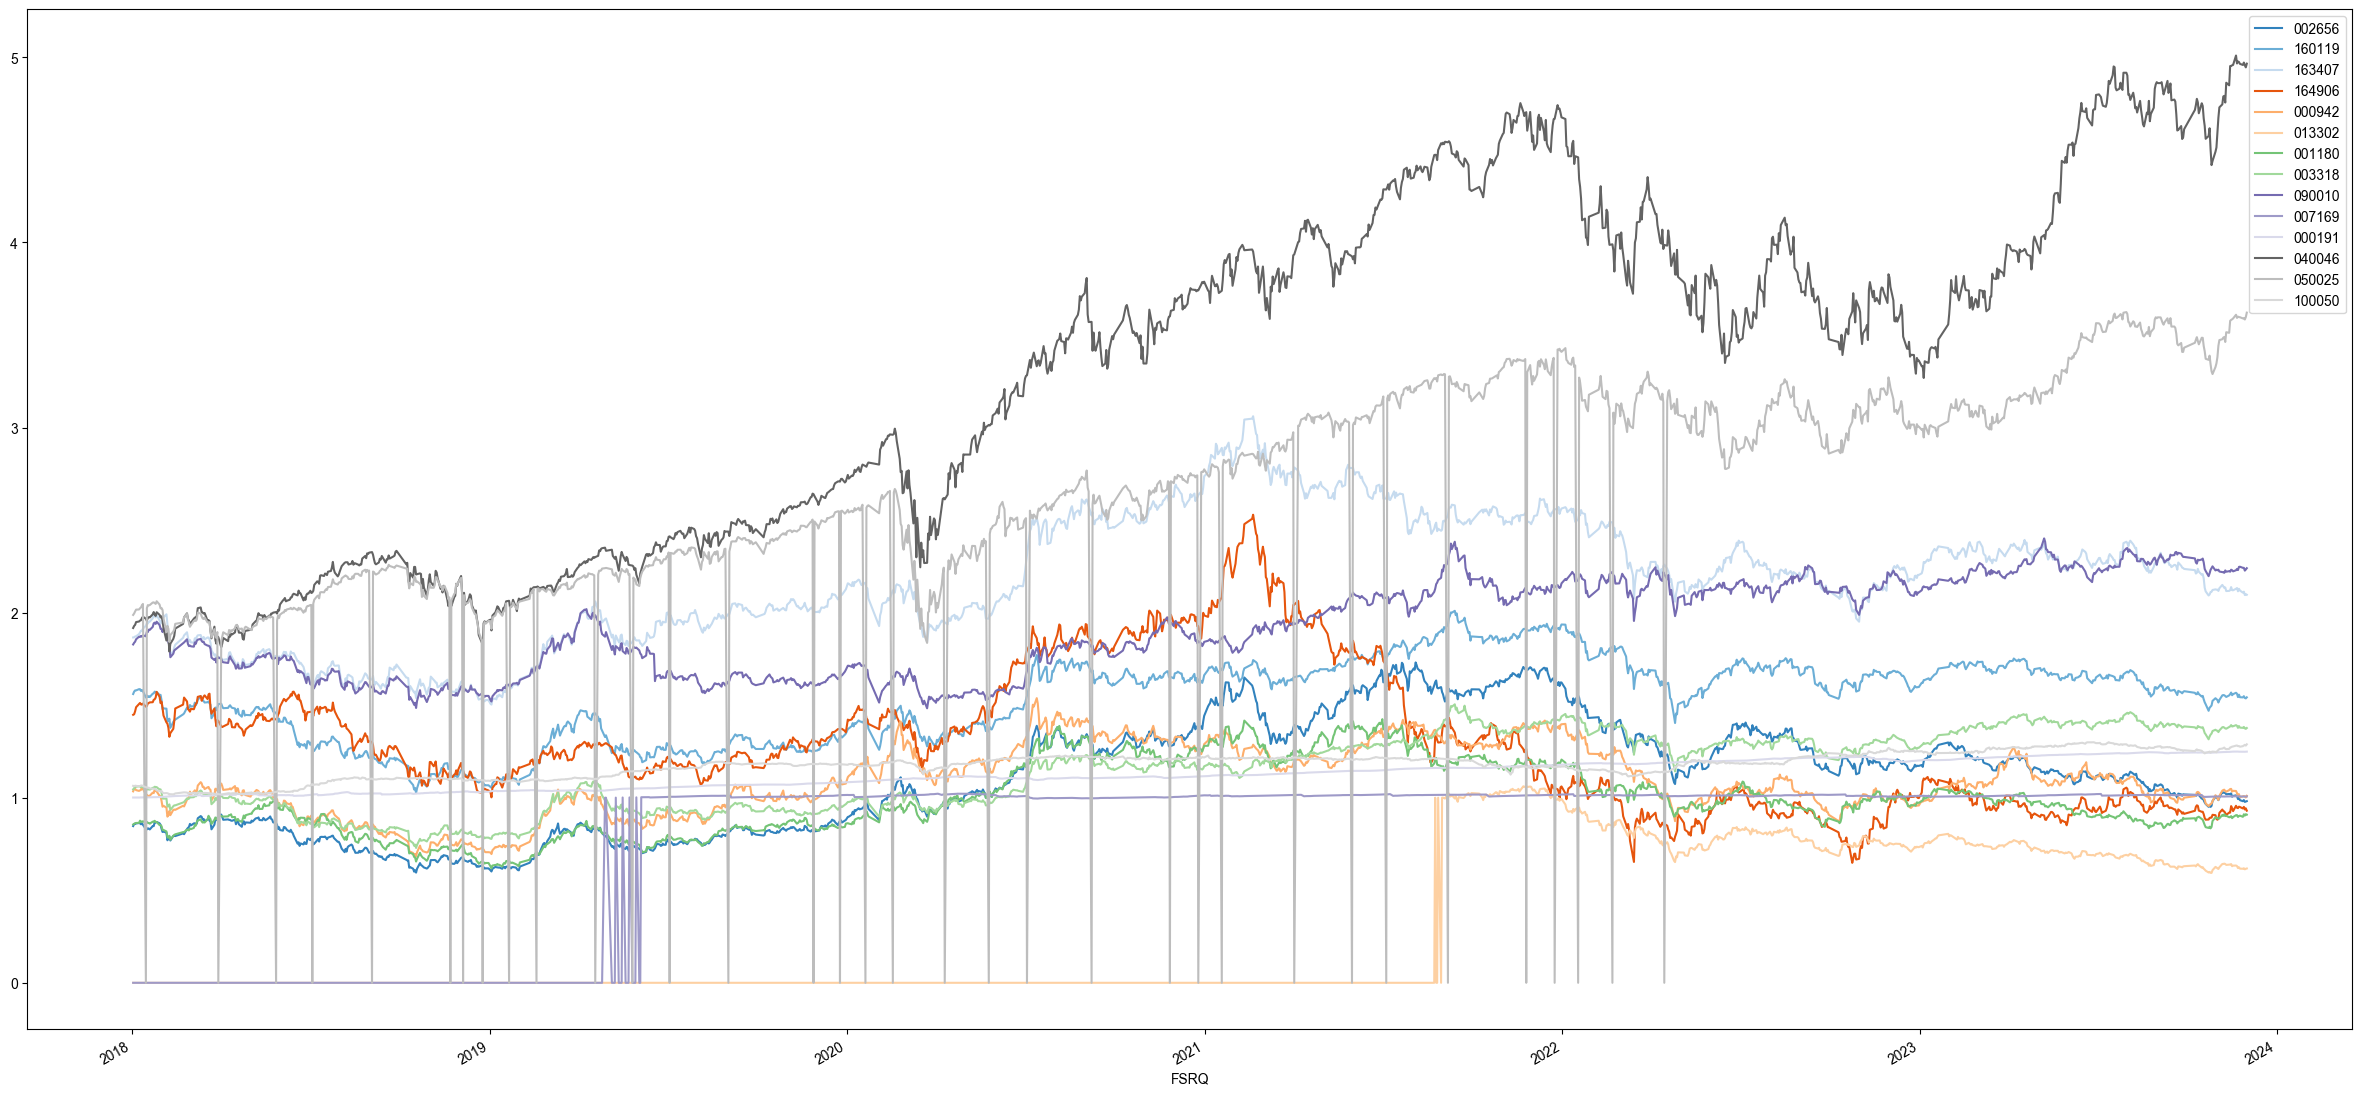

In [43]:
allData = pd.DataFrame(index=fundBT.fundsList['163407']['data'].index, columns=fundBT.fundsList.keys())
for code in fundBT.fundsList.keys():
    allData[code] = fundBT.fundsList[code]['data']['DWJZ']
allData.fillna(0, inplace=True)
allData.plot(figsize=(30,15), colormap='tab20c')

### 测试方案1-1: 20%国外权益债券基金+20%国内债券基金+60%国内权益基金，带3%阈值再平衡

In [44]:
fundBT = FundBT(fundsList= fundsList, loseStatusAssignFundCode= "163407",eachAdditionalCaptital= 5000, rebalanceRate=0.03,inititalCaptital= 10000, startDate="2018-01-01", endDate = "2023-12-01")
fundBT.checkFundData()
fundBT.simulationsCalc()
fundBT.outData()


    """""""""""""""""""""""""""""""""""""""""""""""""""
    所有资金汇总
    
    总投入资金：367559.23899629177， 账户资金：414883.3048996959， 盈亏资金：47324.065903404146， 盈亏率：12.875221428968509
    买入手续费合计：407.9133005046328，卖出手续费合计：90.76100370823403
    """""""""""""""""""""""""""""""""""""""""""""""""""
            
                   基金名字      最早数据时间      最晚数据时间         总投入资金          账户资金  \
0           南方创业板ETF联接A  2018-01-02  2023-12-01  11074.719968  10637.006128   
1    南方中证500ETF联接(LOF)A  2018-01-02  2023-12-01  22304.754698  22882.409711   
2            兴全沪深300增强A  2018-01-02  2023-12-01  53847.799258  56746.770690   
3   交银中证海外中国互联网指数(LOF)A  2018-01-02  2023-12-01  11021.681864   8524.993241   
4             广发信息技术联接A  2018-01-02  2023-12-01  11077.406683  10514.992260   
5      招商中证科创创业50ETF联接A  2021-08-24  2023-12-01   4350.000000   3448.924982   
6             广发医药卫生联接A  2018-01-02  2023-12-01  11149.139659  10718.473433   
7   景顺长城中证500行业中性低波动指数A  2018-01-02  2023-12-01  32925.390064  40792

/var/folders/pt/0889m5h12bn_3bp_j59gg5gc0000gn/T/ipykernel_19125/28390286.py:222: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.totalCaptitalData = pd.concat([self.totalCaptitalData, pd.DataFrame([data], index=[code])], ignore_index=True)


In [46]:
fundBT.totalCaptitalData

,基金名字,最早数据时间,最晚数据时间,总投入资金,账户资金,盈亏资金,盈亏率,最大回撤,买入手续费合计,卖出手续费合计
0,南方创业板ETF联接A,2018-01-02,2023-12-01,11074.719968,10637.006128,-437.713840,-3.952369,65.609474,13.289664,0.000000
1,南方中证500ETF联接(LOF)A,2018-01-02,2023-12-01,22304.754698,22882.409711,577.655013,2.589829,48.992387,26.765706,0.000000
2,兴全沪深300增强A,2018-01-02,2023-12-01,53847.799258,56746.770690,2898.971432,5.383640,50.893470,86.400000,90.761004
3,交银中证海外中国互联网指数(LOF)A,2018-01-02,2023-12-01,11021.681864,8524.993241,-2496.688623,-22.652519,74.377224,13.226018,0.000000
4,广发信息技术联接A,2018-01-02,2023-12-01,11077.406683,10514.992260,-562.414423,-5.077131,55.611183,13.292888,0.000000
5,招商中证科创创业50ETF联接A,2021-08-24,2023-12-01,4350.000000,3448.924982,-901.075018,-20.714368,44.186484,5.220000,0.000000
6,广发医药卫生联接A,2018-01-02,2023-12-01,11149.139659,10718.473433,-430.666227,-3.862775,56.624307,13.378968,0.000000
7,景顺长城中证500行业中性低波动指数A,2018-01-02,2023-12-01,32925.390064,40792.264377,7866.874313,23.893033,51.575169,39.510468,0.000000
8,大成中证红利指数A,2018-01-02,2023-12-01,58627.838745,69483.672877,10855.834132,18.516518,38.234069,70.353406,0.000000
9,易方达中债1-3年国开行债券指数A,2019-04-29,2023-12-01,37314.610368,37251.534221,-63.076148,-0.169039,2.632867,14.925844,0.000000


<Axes: xlabel='FSRQ'>

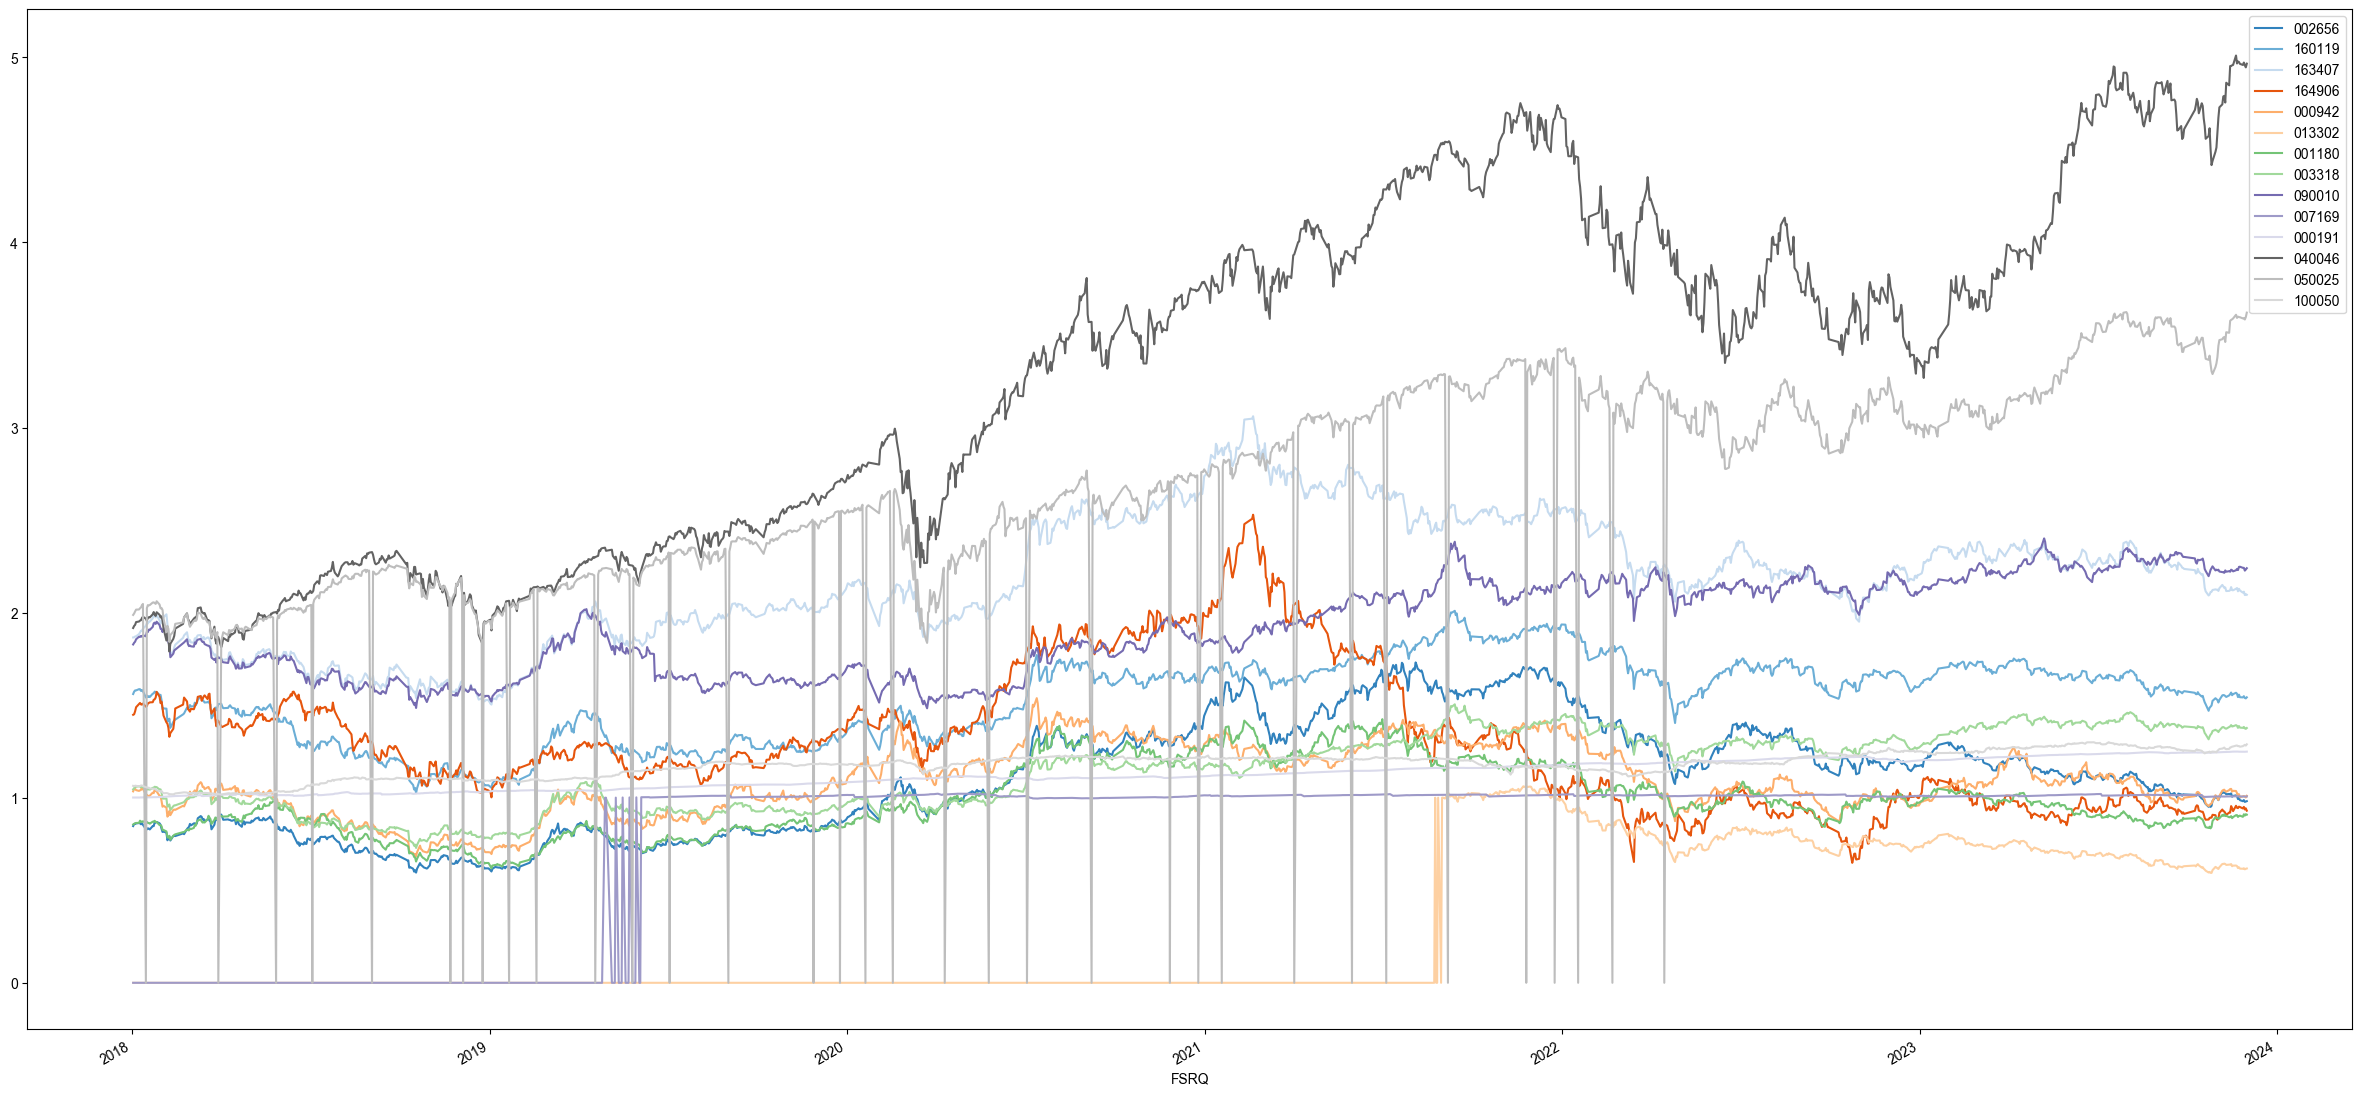

In [47]:
allData = pd.DataFrame(index=fundBT.fundsList['163407']['data'].index, columns=fundBT.fundsList.keys())
for code in fundBT.fundsList.keys():
    allData[code] = fundBT.fundsList[code]['data']['DWJZ']
allData.fillna(0, inplace=True)
allData.plot(figsize=(30,15), colormap='tab20c')

### 测试方案1-2: 20%国外权益债券基金+20%国内债券基金+60%国内权益基金，带1%阈值再平衡

In [48]:
fundBT = FundBT(fundsList= fundsList, loseStatusAssignFundCode= "163407",eachAdditionalCaptital= 5000, rebalanceRate=0.01,inititalCaptital= 10000, startDate="2018-01-01", endDate = "2023-12-01")
fundBT.checkFundData()
fundBT.simulationsCalc()
fundBT.outData()


    """""""""""""""""""""""""""""""""""""""""""""""""""
    所有资金汇总
    
    总投入资金：367308.88149392296， 账户资金：415187.0664457749， 盈亏资金：47878.18495185196， 盈亏率：13.034856319597088
    买入手续费合计：478.75163996337346，卖出手续费合计：341.11850607697534
    """""""""""""""""""""""""""""""""""""""""""""""""""
            
                   基金名字      最早数据时间      最晚数据时间         总投入资金          账户资金  \
0           南方创业板ETF联接A  2018-01-02  2023-12-01  11615.335247  11236.843529   
1    南方中证500ETF联接(LOF)A  2018-01-02  2023-12-01  23154.542392  23834.399222   
2            兴全沪深300增强A  2018-01-02  2023-12-01  53956.633542  56416.653830   
3   交银中证海外中国互联网指数(LOF)A  2018-01-02  2023-12-01  13789.859968  12121.031243   
4             广发信息技术联接A  2018-01-02  2023-12-01  12951.661327  12631.553741   
5      招商中证科创创业50ETF联接A  2021-08-24  2023-12-01  15031.969645  11383.511243   
6             广发医药卫生联接A  2018-01-02  2023-12-01  13113.670454  12930.705600   
7   景顺长城中证500行业中性低波动指数A  2018-01-02  2023-12-01  30085.751605  3863

/var/folders/pt/0889m5h12bn_3bp_j59gg5gc0000gn/T/ipykernel_19125/28390286.py:222: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.totalCaptitalData = pd.concat([self.totalCaptitalData, pd.DataFrame([data], index=[code])], ignore_index=True)


In [49]:
fundBT.totalCaptitalData

,基金名字,最早数据时间,最晚数据时间,总投入资金,账户资金,盈亏资金,盈亏率,最大回撤,买入手续费合计,卖出手续费合计
0,南方创业板ETF联接A,2018-01-02,2023-12-01,11615.335247,11236.843529,-378.491717,-3.258552,65.609474,15.866789,8.034943
1,南方中证500ETF联接(LOF)A,2018-01-02,2023-12-01,23154.542392,23834.399222,679.856830,2.936170,48.992387,27.785451,0.000000
2,兴全沪深300增强A,2018-01-02,2023-12-01,53956.633542,56416.653830,2460.020289,4.559255,50.893470,87.736483,95.785511
3,交银中证海外中国互联网指数(LOF)A,2018-01-02,2023-12-01,13789.859968,12121.031243,-1668.828725,-12.101854,74.377224,19.559841,12.550040
4,广发信息技术联接A,2018-01-02,2023-12-01,12951.661327,12631.553741,-320.107586,-2.471556,55.611183,17.500894,8.162086
5,招商中证科创创业50ETF联接A,2021-08-24,2023-12-01,15031.969645,11383.511243,-3648.458402,-24.271326,44.186484,18.038364,0.000000
6,广发医药卫生联接A,2018-01-02,2023-12-01,13113.670454,12930.705600,-182.964854,-1.395222,56.624307,18.271955,10.564793
7,景顺长城中证500行业中性低波动指数A,2018-01-02,2023-12-01,30085.751605,38634.117245,8548.365640,28.413336,51.575169,43.290858,29.949819
8,大成中证红利指数A,2018-01-02,2023-12-01,51402.344130,63869.284366,12466.940236,24.253641,38.234069,83.097017,89.225849
9,易方达中债1-3年国开行债券指数A,2019-04-29,2023-12-01,42813.973269,42712.141922,-101.831347,-0.237846,2.632867,18.381936,0.000000


<Axes: xlabel='FSRQ'>

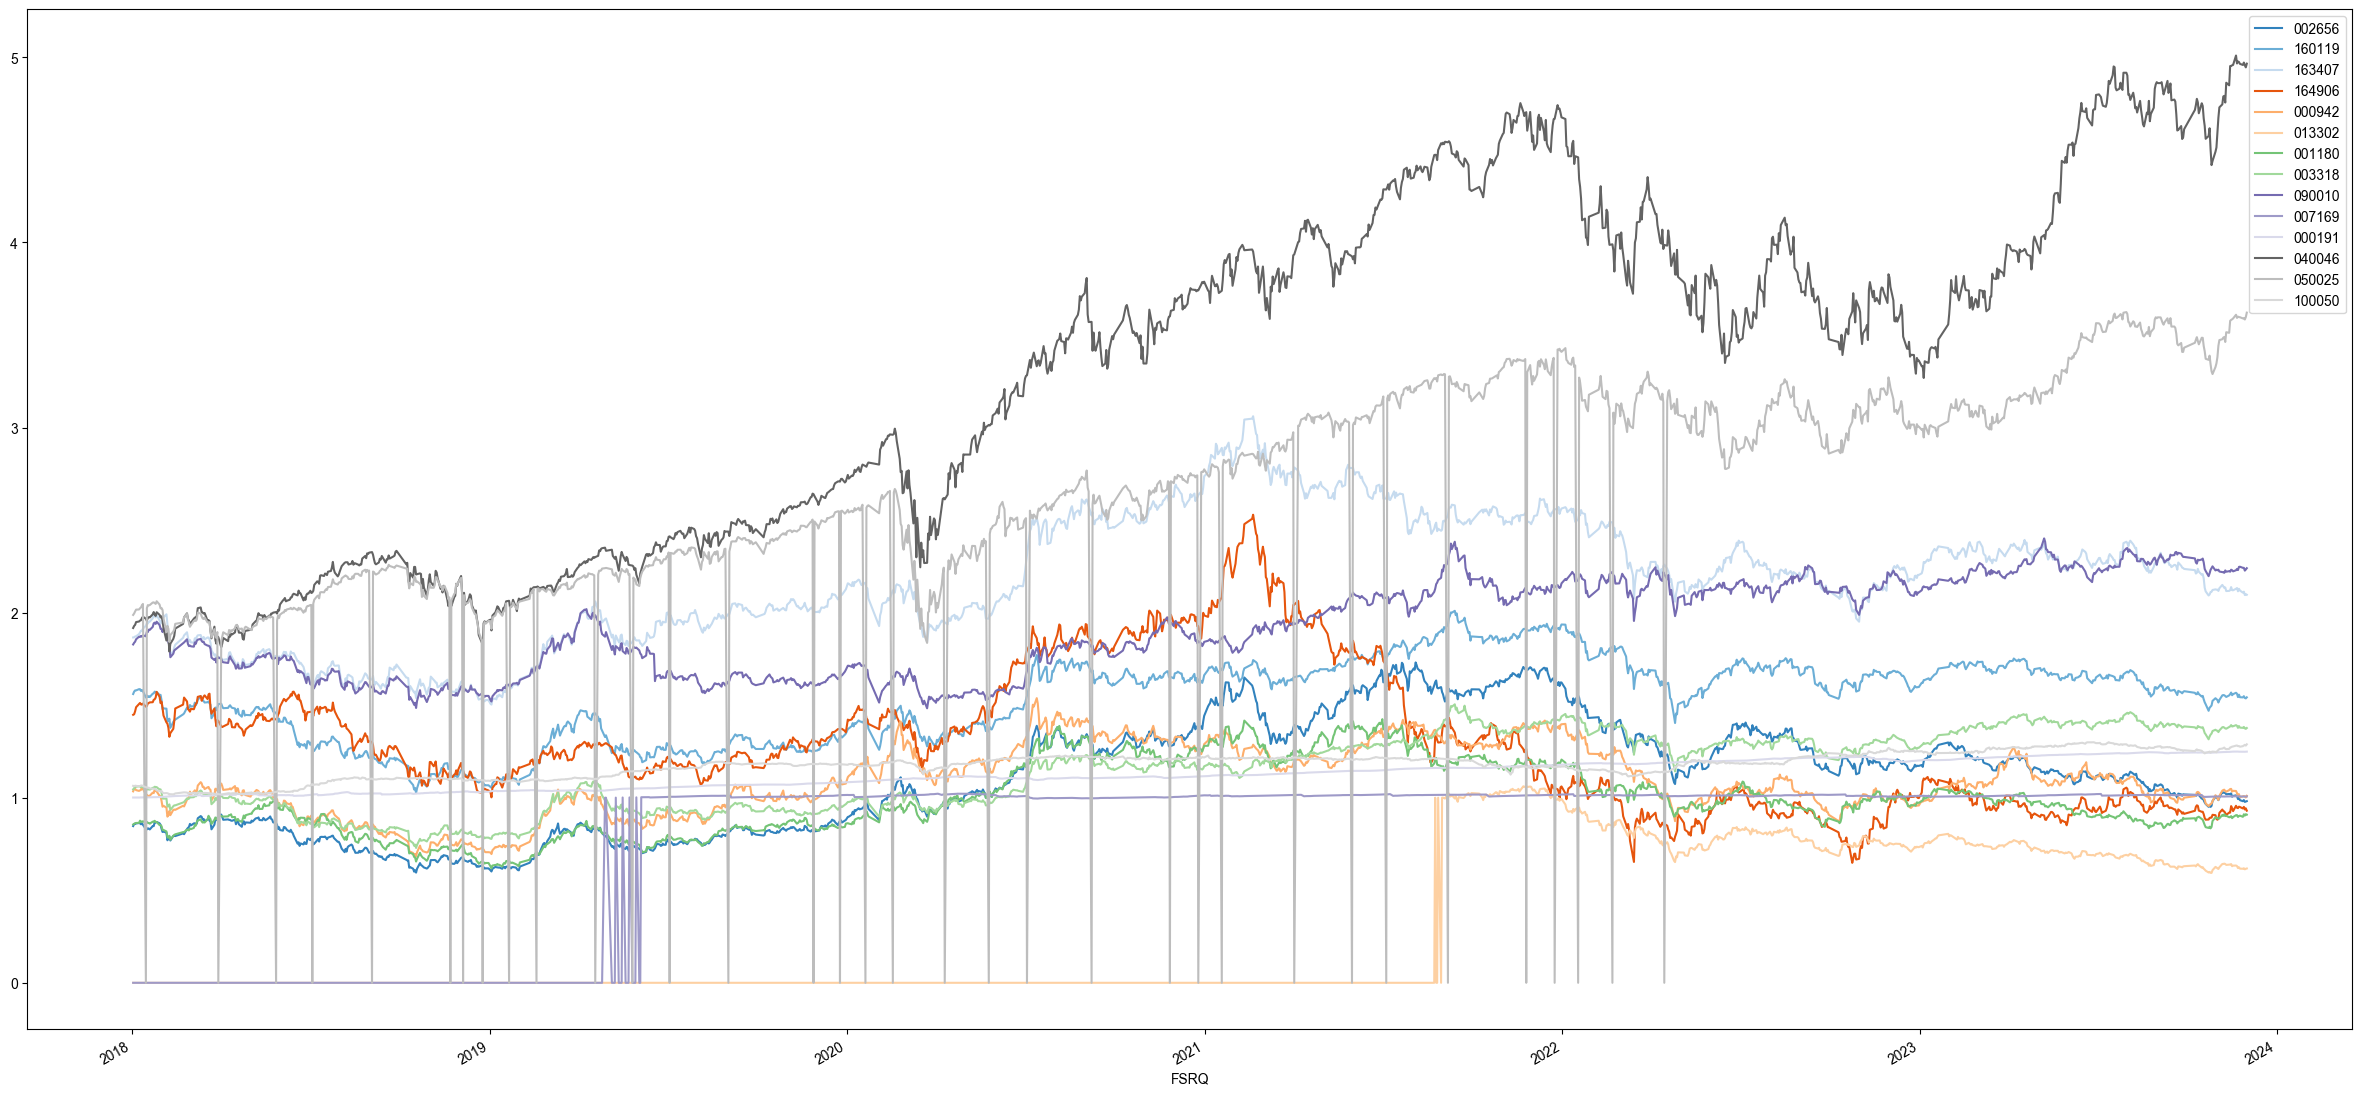

In [50]:
allData = pd.DataFrame(index=fundBT.fundsList['163407']['data'].index, columns=fundBT.fundsList.keys())
for code in fundBT.fundsList.keys():
    allData[code] = fundBT.fundsList[code]['data']['DWJZ']
allData.fillna(0, inplace=True)
allData.plot(figsize=(30,15), colormap='tab20c')

### 测试方案2: 20%国外权益债券基金+20%国内债券基金+60%国内权益基金，不带再平衡

In [51]:
fundBT = FundBT(fundsList= fundsList, loseStatusAssignFundCode= "163407",eachAdditionalCaptital= 5000, onRebalance=False,inititalCaptital= 10000, startDate="2018-01-01", endDate = "2023-12-01")
fundBT.checkFundData()
fundBT.simulationsCalc()
fundBT.outData()


    """""""""""""""""""""""""""""""""""""""""""""""""""
    所有资金汇总
    
    总投入资金：367650.0， 账户资金：412247.7248810097， 盈亏资金：44597.72488100972， 盈亏率：12.130484123761654
    买入手续费合计：395.02，卖出手续费合计：0.0
    """""""""""""""""""""""""""""""""""""""""""""""""""
            
                   基金名字      最早数据时间      最晚数据时间    总投入资金          账户资金  \
0           南方创业板ETF联接A  2018-01-02  2023-12-01  10950.0  10482.671936   
1    南方中证500ETF联接(LOF)A  2018-01-02  2023-12-01  21900.0  22414.608385   
2            兴全沪深300增强A  2018-01-02  2023-12-01  72000.0  73756.361334   
3   交银中证海外中国互联网指数(LOF)A  2018-01-02  2023-12-01  10950.0   8472.810778   
4             广发信息技术联接A  2018-01-02  2023-12-01  10950.0  10377.687060   
5      招商中证科创创业50ETF联接A  2021-08-24  2023-12-01   4350.0   3448.924982   
6             广发医药卫生联接A  2018-01-02  2023-12-01  10950.0  10494.131382   
7   景顺长城中证500行业中性低波动指数A  2018-01-02  2023-12-01  32850.0  40687.361772   
8             大成中证红利指数A  2018-01-02  2023-12-01  54750.0  64813.682132

/var/folders/pt/0889m5h12bn_3bp_j59gg5gc0000gn/T/ipykernel_19125/28390286.py:222: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.totalCaptitalData = pd.concat([self.totalCaptitalData, pd.DataFrame([data], index=[code])], ignore_index=True)


In [52]:
fundBT.totalCaptitalData

,基金名字,最早数据时间,最晚数据时间,总投入资金,账户资金,盈亏资金,盈亏率,最大回撤,买入手续费合计,卖出手续费合计
0,南方创业板ETF联接A,2018-01-02,2023-12-01,10950.0,10482.671936,-467.328064,-4.267836,65.609474,13.14,0.0
1,南方中证500ETF联接(LOF)A,2018-01-02,2023-12-01,21900.0,22414.608385,514.608385,2.349810,48.992387,26.28,0.0
2,兴全沪深300增强A,2018-01-02,2023-12-01,72000.0,73756.361334,1756.361334,2.439391,50.893470,86.40,0.0
3,交银中证海外中国互联网指数(LOF)A,2018-01-02,2023-12-01,10950.0,8472.810778,-2477.189222,-22.622733,74.377224,13.14,0.0
4,广发信息技术联接A,2018-01-02,2023-12-01,10950.0,10377.687060,-572.312940,-5.226602,55.611183,13.14,0.0
5,招商中证科创创业50ETF联接A,2021-08-24,2023-12-01,4350.0,3448.924982,-901.075018,-20.714368,44.186484,5.22,0.0
6,广发医药卫生联接A,2018-01-02,2023-12-01,10950.0,10494.131382,-455.868618,-4.163184,56.624307,13.14,0.0
7,景顺长城中证500行业中性低波动指数A,2018-01-02,2023-12-01,32850.0,40687.361772,7837.361772,23.858027,51.575169,39.42,0.0
8,大成中证红利指数A,2018-01-02,2023-12-01,54750.0,64813.682132,10063.682132,18.381155,38.234069,65.70,0.0
9,易方达中债1-3年国开行债券指数A,2019-04-29,2023-12-01,28500.0,28381.415430,-118.584570,-0.416086,2.632867,11.40,0.0


<Axes: xlabel='FSRQ'>

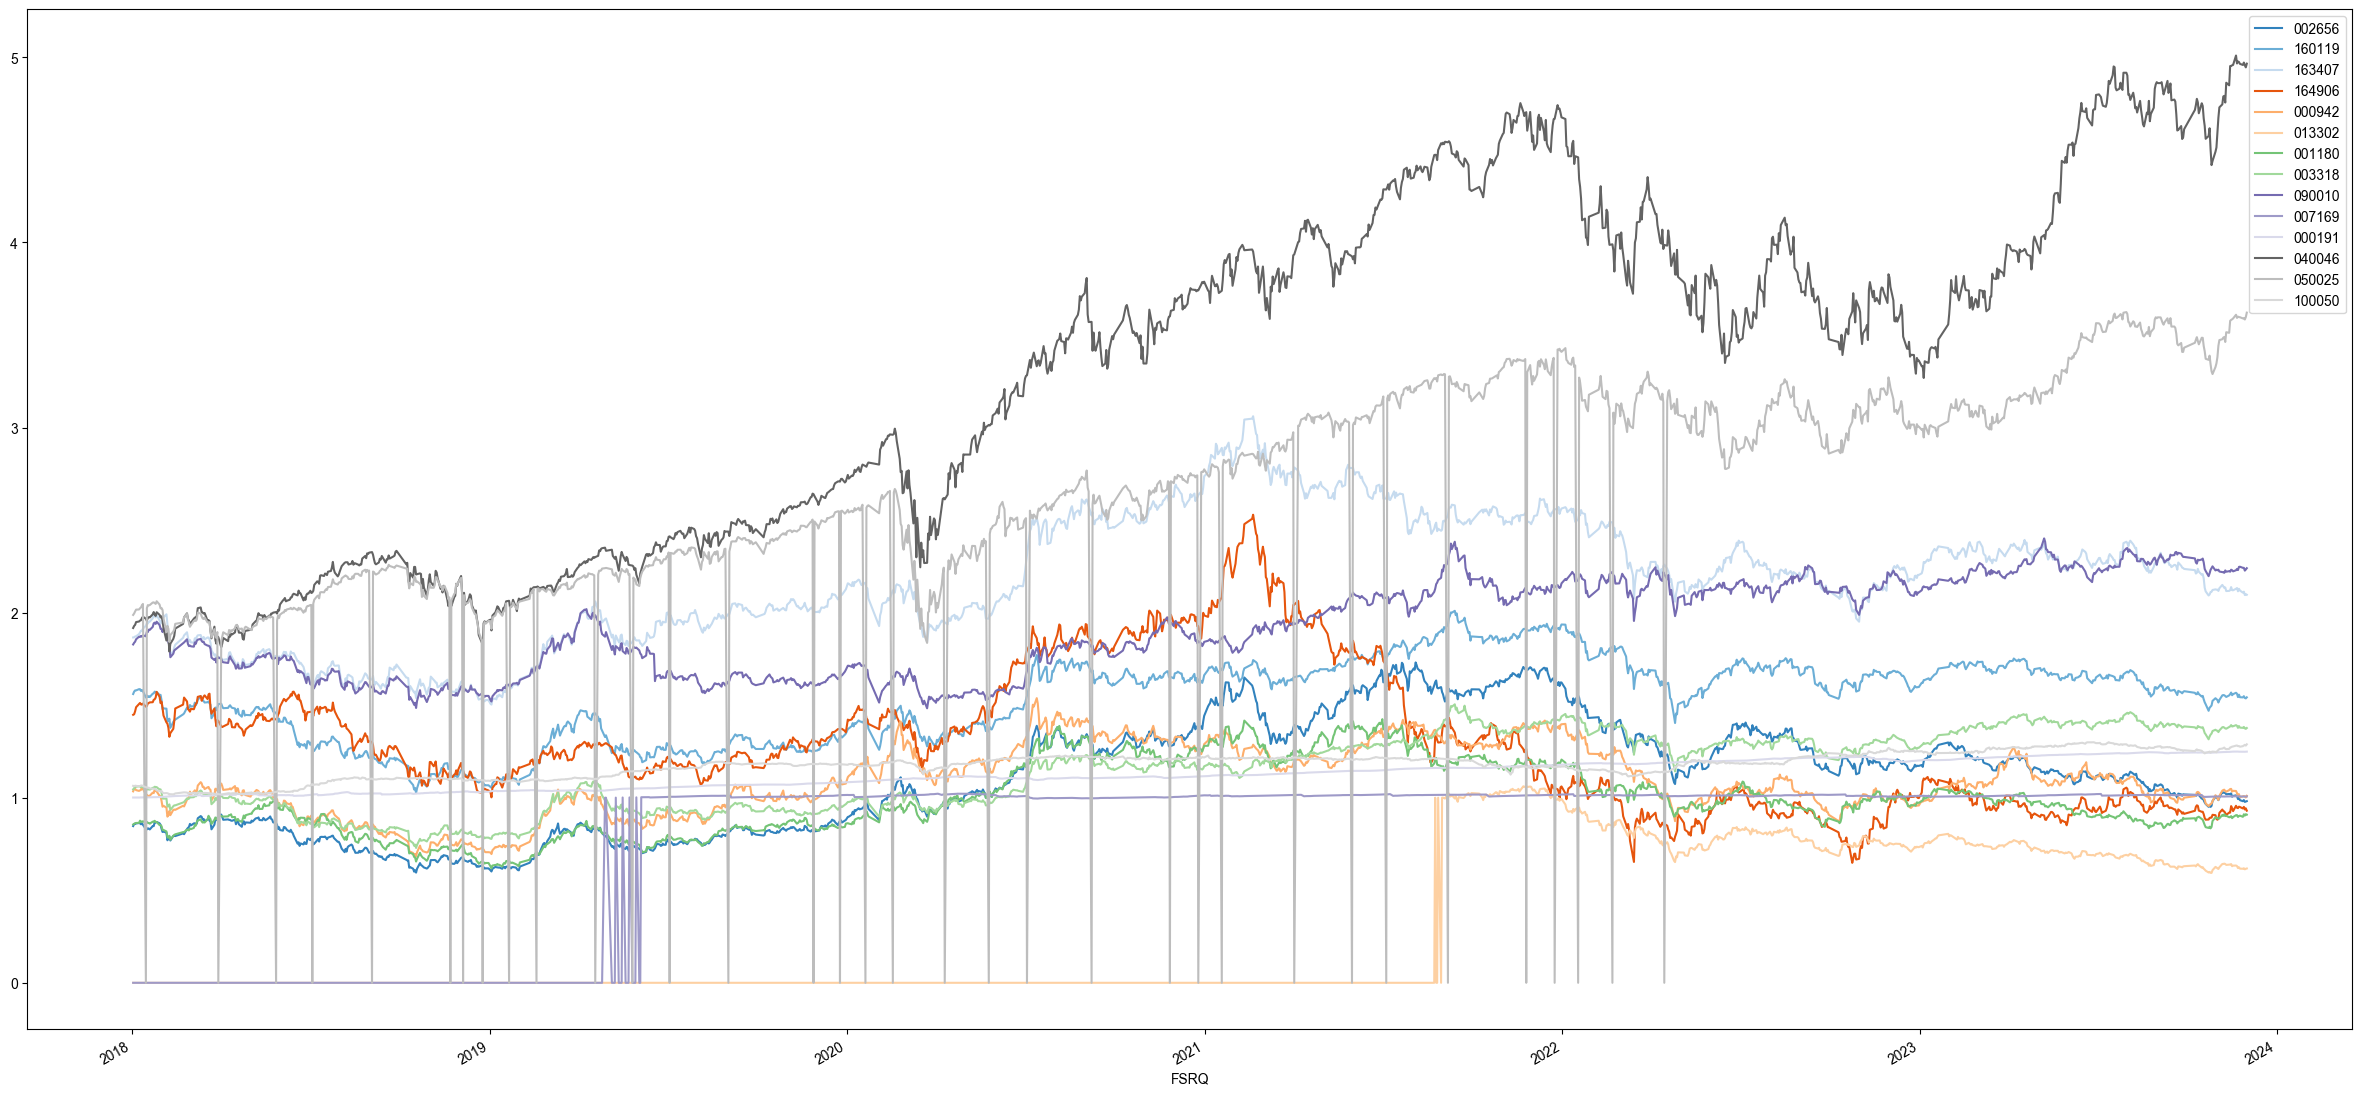

In [53]:
allData = pd.DataFrame(index=fundBT.fundsList['163407']['data'].index, columns=fundBT.fundsList.keys())
for code in fundBT.fundsList.keys():
    allData[code] = fundBT.fundsList[code]['data']['DWJZ']
allData.fillna(0, inplace=True)
allData.plot(figsize=(30,15), colormap='tab20c')

### 测试方案3: 现有方案，带5%再平衡

In [54]:
# 现有方案
fundsList = [{
  "code": "002656", # 基金代码
  "name": "南方创业板ETF联接A", # 基金名称
  "rate": 0.05, # 投资组合中基金的占比
  "purchaseFee": 0.0012, # 购买手续费
  "sellFee": 0.005, # 卖出手续费
},{
  "code": "160119", # 基金代码
  "name": "南方中证500ETF联接(LOF)A", # 基金名称
  "rate": 0.15, # 投资组合中基金的占比
  "purchaseFee": 0.0012, # 购买手续费
  "sellFee": 0.005, # 卖出手续费
},{
  "code": "163407", # 基金代码
  "name": "兴全沪深300增强A", # 基金名称
  "rate": 0.15, # 投资组合中基金的占比
  "purchaseFee": 0.0012, # 购买手续费
  "sellFee": 0.005, # 卖出手续费
},{
  "code": "090010", # 基金代码
  "name": "大成中证红利指数A", # 基金名称
  "rate": 0.15, # 投资组合中基金的占比
  "purchaseFee": 0.0012, # 购买手续费
  "sellFee": 0.005, # 卖出手续费
},{
  "code": "007169", # 基金代码
  "name": "易方达中债1-3年国开行债券指数A", # 基金名称
  "rate": 0.15, # 投资组合中基金的占比
  "purchaseFee": 0.0004, # 购买手续费
  "sellFee": 0, # 卖出手续费
},{
  "code": "000191", # 基金代码
  "name": "富国信用债债券A", # 基金名称
  "rate": 0.15, # 投资组合中基金的占比
  "purchaseFee": 0.0008, # 购买手续费
  "sellFee": 0.001, # 卖出手续费
},{
  "code": "040046", # 基金代码
  "name": "华安纳斯达克100ETF联接QDII", # 基金名称
  "rate": 0.04, # 投资组合中基金的占比
  "purchaseFee": 0.0012, # 购买手续费
  "sellFee": 0, # 卖出手续费
},{
  "code": "050025", # 基金代码
  "name": "博时标普500ETF联接QDII", # 基金名称
  "rate": 0.1, # 投资组合中基金的占比
  "purchaseFee": 0.0012, # 购买手续费
  "sellFee": 0.005, # 卖出手续费
},{
  "code": "100050", # 基金代码
  "name": "富国全球债券QDII", # 基金名称
  "rate": 0.06, # 投资组合中基金的占比
  "purchaseFee": 0.0008, # 购买手续费
  "sellFee": 0.003, # 卖出手续费
}]

In [55]:
fundBT = FundBT(fundsList= fundsList, loseStatusAssignFundCode= "163407",eachAdditionalCaptital= 5000, rebalanceRate=0.03,inititalCaptital= 10000, startDate="2018-01-01", endDate = "2023-12-01")
fundBT.checkFundData()
fundBT.simulationsCalc()
fundBT.outData()


    """""""""""""""""""""""""""""""""""""""""""""""""""
    所有资金汇总
    
    总投入资金：368135.2561043931， 账户资金：415019.80046128033， 盈亏资金：46884.54435688723， 盈亏率：12.735684393018865
    买入手续费合计：391.9089496736105，卖出手续费合计：114.74389560687536
    """""""""""""""""""""""""""""""""""""""""""""""""""
            
                 基金名字      最早数据时间      最晚数据时间         总投入资金          账户资金  \
0         南方创业板ETF联接A  2018-01-02  2023-12-01  18456.551342  17726.715970   
1  南方中证500ETF联接(LOF)A  2018-01-02  2023-12-01  55757.940929  57201.463842   
2          兴全沪深300增强A  2018-01-02  2023-12-01  47051.220879  50288.787249   
3           大成中证红利指数A  2018-01-02  2023-12-01  57977.284594  68721.325274   
4   易方达中债1-3年国开行债券指数A  2019-04-29  2023-12-01  55728.893062  55632.748450   
5            富国信用债债券A  2018-01-02  2023-12-01  59837.702169  66868.514151   
6  华安纳斯达克100ETF联接QDII  2018-01-02  2023-12-01  14600.000000  24000.478489   
7    博时标普500ETF联接QDII  2018-01-02  2023-12-01  36541.419929  50310.908187   
8      

/var/folders/pt/0889m5h12bn_3bp_j59gg5gc0000gn/T/ipykernel_19125/28390286.py:222: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.totalCaptitalData = pd.concat([self.totalCaptitalData, pd.DataFrame([data], index=[code])], ignore_index=True)


In [56]:
fundBT.totalCaptitalData

,基金名字,最早数据时间,最晚数据时间,总投入资金,账户资金,盈亏资金,盈亏率,最大回撤,买入手续费合计,卖出手续费合计
0,南方创业板ETF联接A,2018-01-02,2023-12-01,18456.551342,17726.715970,-729.835372,-3.954343,65.609474,22.147862,0.000000
1,南方中证500ETF联接(LOF)A,2018-01-02,2023-12-01,55757.940929,57201.463842,1443.522913,2.588910,48.992387,66.909529,0.000000
2,兴全沪深300增强A,2018-01-02,2023-12-01,47051.220879,50288.787249,3237.566370,6.880940,50.893470,84.000000,114.743896
3,大成中证红利指数A,2018-01-02,2023-12-01,57977.284594,68721.325274,10744.040679,18.531466,38.234069,69.572742,0.000000
4,易方达中债1-3年国开行债券指数A,2019-04-29,2023-12-01,55728.893062,55632.748450,-96.144612,-0.172522,2.632867,22.291557,0.000000
5,富国信用债债券A,2018-01-02,2023-12-01,59837.702169,66868.514151,7030.811982,11.749803,19.887955,47.870162,0.000000
6,华安纳斯达克100ETF联接QDII,2018-01-02,2023-12-01,14600.000000,24000.478489,9400.478489,64.386839,64.271457,17.520000,0.000000
7,博时标普500ETF联接QDII,2018-01-02,2023-12-01,36541.419929,50310.908187,13769.488258,37.681864,49.323914,43.849704,0.000000
8,富国全球债券QDII,2018-01-02,2023-12-01,22184.243200,24268.858849,2084.615649,9.396830,21.987998,17.747395,0.000000


<Axes: xlabel='FSRQ'>

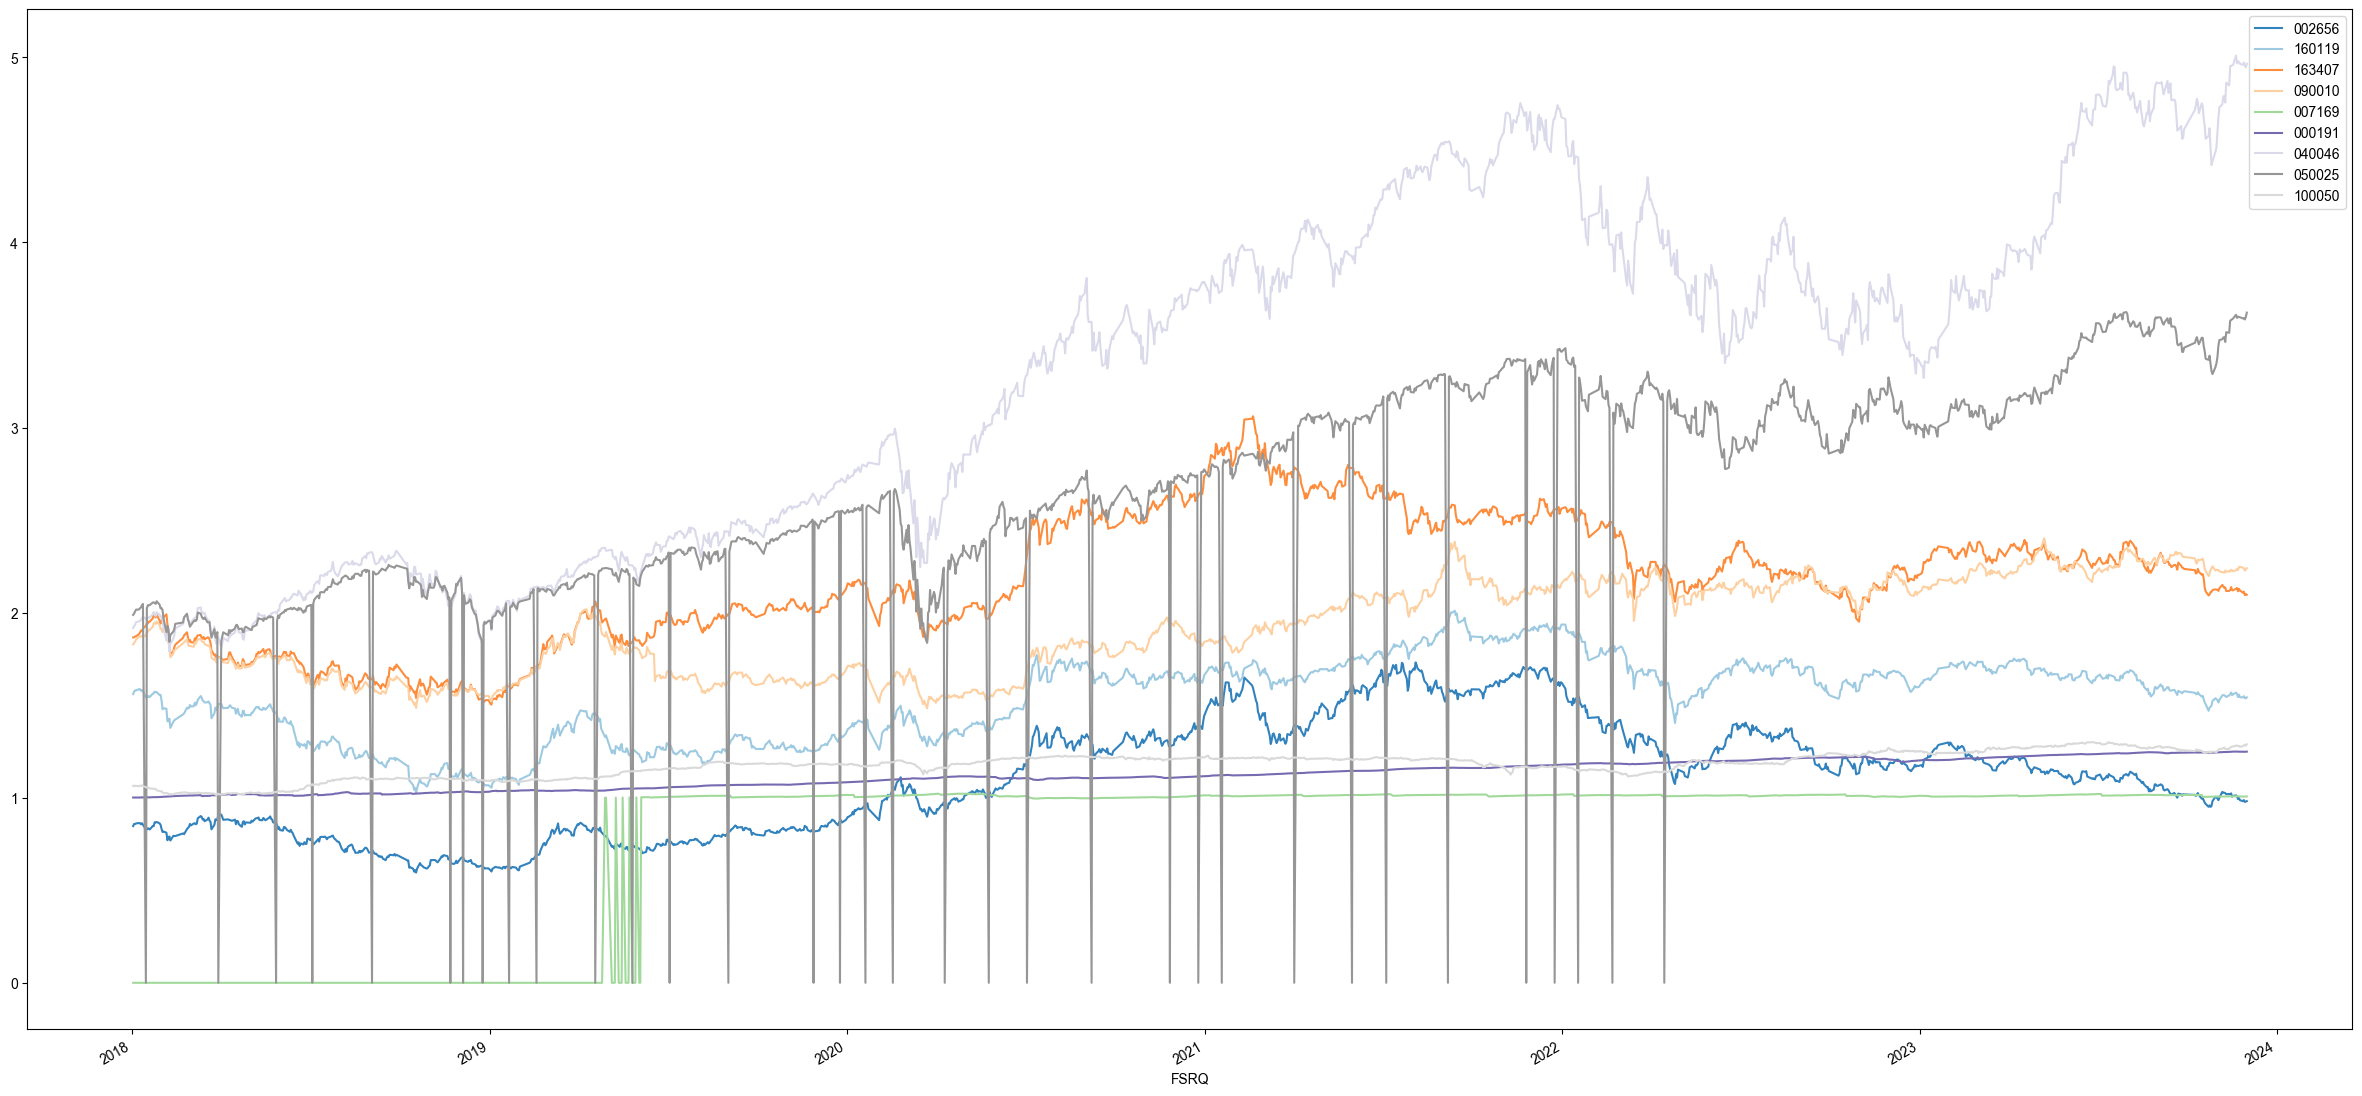

In [57]:
allData = pd.DataFrame(index=fundBT.fundsList['163407']['data'].index, columns=fundBT.fundsList.keys())
for code in fundBT.fundsList.keys():
    allData[code] = fundBT.fundsList[code]['data']['DWJZ']
allData.fillna(0, inplace=True)
allData.plot(figsize=(30,15), colormap='tab20c')

### 测试方案4: 现有方案，不带再平衡

In [58]:
fundBT = FundBT(fundsList= fundsList, loseStatusAssignFundCode= "163407",eachAdditionalCaptital= 5000, onRebalance=False,inititalCaptital= 10000, startDate="2018-01-01", endDate = "2023-12-01")
fundBT.checkFundData()
fundBT.simulationsCalc()
fundBT.outData()


    """""""""""""""""""""""""""""""""""""""""""""""""""
    所有资金汇总
    
    总投入资金：368250.0， 账户资金：412668.771912086， 盈亏资金：44418.771912086， 盈亏率：12.062124076601766
    买入手续费合计：377.03999999999996，卖出手续费合计：0.0
    """""""""""""""""""""""""""""""""""""""""""""""""""
            
                 基金名字      最早数据时间      最晚数据时间    总投入资金          账户资金  \
0         南方创业板ETF联接A  2018-01-02  2023-12-01  18250.0  17471.119893   
1  南方中证500ETF联接(LOF)A  2018-01-02  2023-12-01  54750.0  56036.520964   
2          兴全沪深300增强A  2018-01-02  2023-12-01  70000.0  72491.749787   
3           大成中证红利指数A  2018-01-02  2023-12-01  54750.0  64813.682132   
4   易方达中债1-3年国开行债券指数A  2019-04-29  2023-12-01  42750.0  42572.123145   
5            富国信用债债券A  2018-01-02  2023-12-01  54750.0  61096.518904   
6  华安纳斯达克100ETF联接QDII  2018-01-02  2023-12-01  14600.0  24000.478489   
7    博时标普500ETF联接QDII  2018-01-02  2023-12-01  36500.0  50244.490896   
8          富国全球债券QDII  2018-01-02  2023-12-01  21900.0  23942.087702   

      

/var/folders/pt/0889m5h12bn_3bp_j59gg5gc0000gn/T/ipykernel_19125/28390286.py:222: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.totalCaptitalData = pd.concat([self.totalCaptitalData, pd.DataFrame([data], index=[code])], ignore_index=True)


In [59]:
fundBT.totalCaptitalData

,基金名字,最早数据时间,最晚数据时间,总投入资金,账户资金,盈亏资金,盈亏率,最大回撤,买入手续费合计,卖出手续费合计
0,南方创业板ETF联接A,2018-01-02,2023-12-01,18250.0,17471.119893,-778.880107,-4.267836,65.609474,21.90,0.0
1,南方中证500ETF联接(LOF)A,2018-01-02,2023-12-01,54750.0,56036.520964,1286.520964,2.349810,48.992387,65.70,0.0
2,兴全沪深300增强A,2018-01-02,2023-12-01,70000.0,72491.749787,2491.749787,3.559643,50.893470,84.00,0.0
3,大成中证红利指数A,2018-01-02,2023-12-01,54750.0,64813.682132,10063.682132,18.381155,38.234069,65.70,0.0
4,易方达中债1-3年国开行债券指数A,2019-04-29,2023-12-01,42750.0,42572.123145,-177.876855,-0.416086,2.632867,17.10,0.0
5,富国信用债债券A,2018-01-02,2023-12-01,54750.0,61096.518904,6346.518904,11.591815,19.887955,43.80,0.0
6,华安纳斯达克100ETF联接QDII,2018-01-02,2023-12-01,14600.0,24000.478489,9400.478489,64.386839,64.271457,17.52,0.0
7,博时标普500ETF联接QDII,2018-01-02,2023-12-01,36500.0,50244.490896,13744.490896,37.656139,49.323914,43.80,0.0
8,富国全球债券QDII,2018-01-02,2023-12-01,21900.0,23942.087702,2042.087702,9.324601,21.987998,17.52,0.0


<Axes: xlabel='FSRQ'>

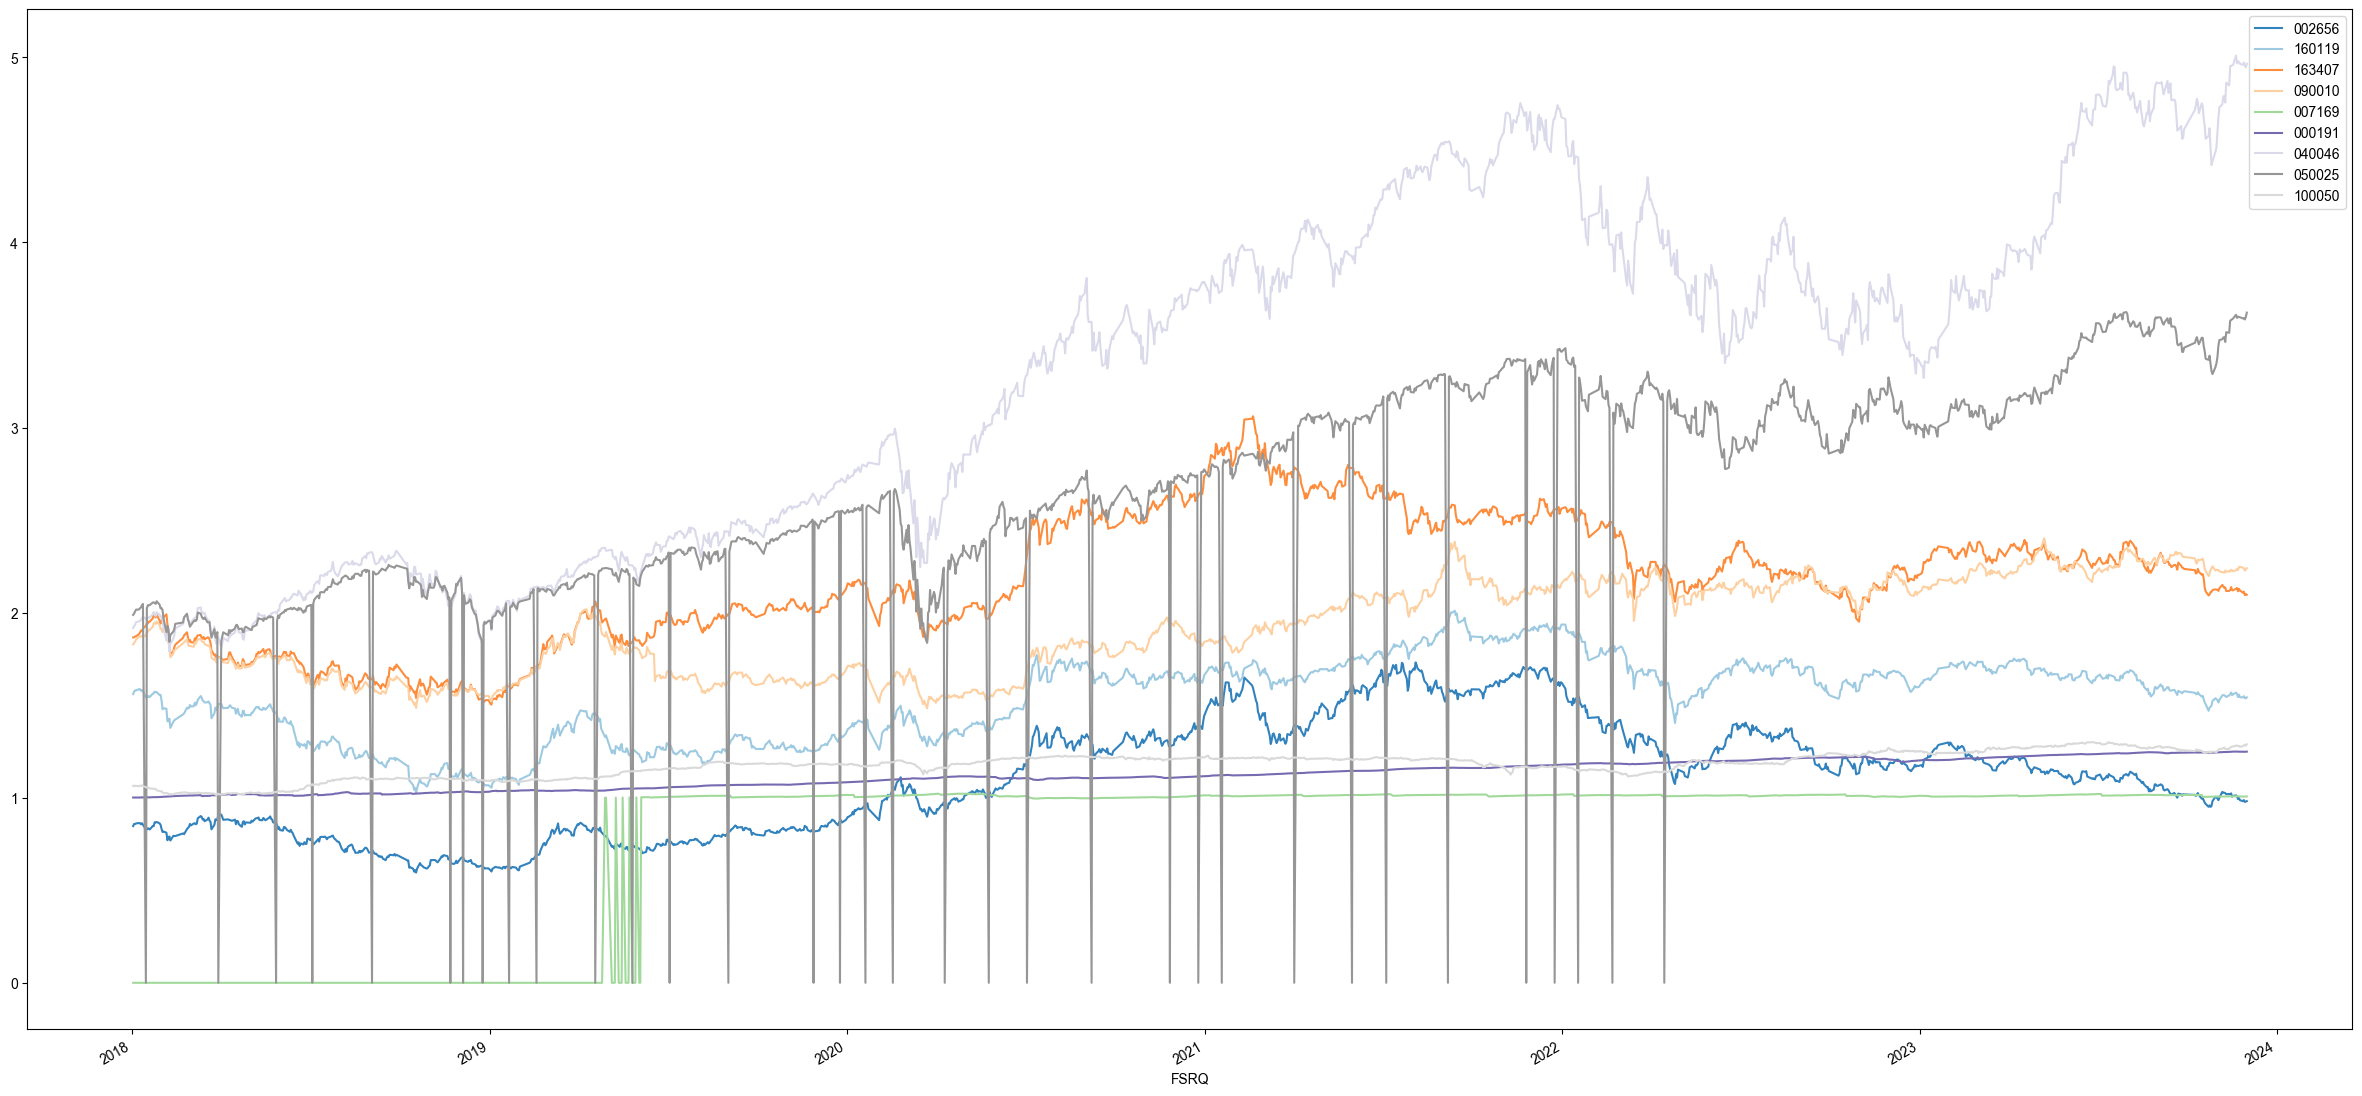

In [60]:
allData = pd.DataFrame(index=fundBT.fundsList['163407']['data'].index, columns=fundBT.fundsList.keys())
for code in fundBT.fundsList.keys():
    allData[code] = fundBT.fundsList[code]['data']['DWJZ']
allData.fillna(0, inplace=True)
allData.plot(figsize=(30,15), colormap='tab20c')

# 用户输入段

In [31]:
# 调整方案
fundsList = [{
  "code": "002656", # 基金代码
  "name": "南方创业板ETF联接A", # 基金名称
  "rate": 0.03, # 投资组合中基金的占比
  "purchaseFee": 0.0012, # 购买手续费
  "sellFee": 0.005, # 卖出手续费
},{
  "code": "160119", # 基金代码
  "name": "南方中证500ETF联接(LOF)A", # 基金名称
  "rate": 0.06, # 投资组合中基金的占比
  "purchaseFee": 0.0012, # 购买手续费
  "sellFee": 0.005, # 卖出手续费
},{
  "code": "163407", # 基金代码
  "name": "兴全沪深300增强A", # 基金名称
  "rate": 0.15, # 投资组合中基金的占比
  "purchaseFee": 0.0012, # 购买手续费
  "sellFee": 0.005, # 卖出手续费
},{
  "code": "164906", # 基金代码
  "name": "交银中证海外中国互联网指数(LOF)A", # 基金名称
  "rate": 0.03, # 投资组合中基金的占比
  "purchaseFee": 0.0012, # 购买手续费
  "sellFee": 0.005, # 卖出手续费
},{
  "code": "000942", # 基金代码
  "name": "广发信息技术联接A", # 基金名称
  "rate": 0.03, # 投资组合中基金的占比
  "purchaseFee": 0.0012, # 购买手续费
  "sellFee": 0.005, # 卖出手续费
},{
  "code": "013302", # 基金代码
  "name": "招商中证科创创业50ETF联接A", # 基金名称
  "rate": 0.03, # 投资组合中基金的占比
  "purchaseFee": 0.0012, # 购买手续费
  "sellFee": 0.005, # 卖出手续费
},{
  "code": "001180", # 基金代码
  "name": "广发医药卫生联接A", # 基金名称
  "rate": 0.03, # 投资组合中基金的占比
  "purchaseFee": 0.0012, # 购买手续费
  "sellFee": 0.005, # 卖出手续费
},{
  "code": "003318", # 基金代码
  "name": "景顺长城中证500行业中性低波动指数A", # 基金名称
  "rate": 0.09, # 投资组合中基金的占比
  "purchaseFee": 0.0012, # 购买手续费
  "sellFee": 0.005, # 卖出手续费
},{
  "code": "090010", # 基金代码
  "name": "大成中证红利指数A", # 基金名称
  "rate": 0.15, # 投资组合中基金的占比
  "purchaseFee": 0.0012, # 购买手续费
  "sellFee": 0.005, # 卖出手续费
},{
  "code": "007169", # 基金代码
  "name": "易方达中债1-3年国开行债券指数A", # 基金名称
  "rate": 0.1, # 投资组合中基金的占比
  "purchaseFee": 0.0004, # 购买手续费
  "sellFee": 0, # 卖出手续费
},{
  "code": "000191", # 基金代码
  "name": "富国信用债债券A", # 基金名称
  "rate": 0.1, # 投资组合中基金的占比
  "purchaseFee": 0.0008, # 购买手续费
  "sellFee": 0.001, # 卖出手续费
},{
  "code": "040046", # 基金代码
  "name": "华安纳斯达克100ETF联接QDII", # 基金名称
  "rate": 0.04, # 投资组合中基金的占比
  "purchaseFee": 0.0012, # 购买手续费
  "sellFee": 0, # 卖出手续费
},{
  "code": "050025", # 基金代码
  "name": "博时标普500ETF联接QDII", # 基金名称
  "rate": 0.1, # 投资组合中基金的占比
  "purchaseFee": 0.0012, # 购买手续费
  "sellFee": 0.005, # 卖出手续费
},{
  "code": "100050", # 基金代码
  "name": "富国全球债券QDII", # 基金名称
  "rate": 0.06, # 投资组合中基金的占比
  "purchaseFee": 0.0008, # 购买手续费
  "sellFee": 0.003, # 卖出手续费
}]

In [1499]:
# 现有方案
fundsList = [{
  "code": "002656", # 基金代码
  "name": "南方创业板ETF联接A", # 基金名称
  "rate": 0.05, # 投资组合中基金的占比
  "purchaseFee": 0.0012, # 购买手续费
  "sellFee": 0.005, # 卖出手续费
},{
  "code": "160119", # 基金代码
  "name": "南方中证500ETF联接(LOF)A", # 基金名称
  "rate": 0.15, # 投资组合中基金的占比
  "purchaseFee": 0.0012, # 购买手续费
  "sellFee": 0.005, # 卖出手续费
},{
  "code": "163407", # 基金代码
  "name": "兴全沪深300增强A", # 基金名称
  "rate": 0.15, # 投资组合中基金的占比
  "purchaseFee": 0.0012, # 购买手续费
  "sellFee": 0.005, # 卖出手续费
},{
  "code": "090010", # 基金代码
  "name": "大成中证红利指数A", # 基金名称
  "rate": 0.15, # 投资组合中基金的占比
  "purchaseFee": 0.0012, # 购买手续费
  "sellFee": 0.005, # 卖出手续费
},{
  "code": "007169", # 基金代码
  "name": "易方达中债1-3年国开行债券指数A", # 基金名称
  "rate": 0.15, # 投资组合中基金的占比
  "purchaseFee": 0.0004, # 购买手续费
  "sellFee": 0, # 卖出手续费
},{
  "code": "000191", # 基金代码
  "name": "富国信用债债券A", # 基金名称
  "rate": 0.15, # 投资组合中基金的占比
  "purchaseFee": 0.0008, # 购买手续费
  "sellFee": 0.001, # 卖出手续费
},{
  "code": "040046", # 基金代码
  "name": "华安纳斯达克100ETF联接QDII", # 基金名称
  "rate": 0.04, # 投资组合中基金的占比
  "purchaseFee": 0.0012, # 购买手续费
  "sellFee": 0, # 卖出手续费
},{
  "code": "050025", # 基金代码
  "name": "博时标普500ETF联接QDII", # 基金名称
  "rate": 0.1, # 投资组合中基金的占比
  "purchaseFee": 0.0012, # 购买手续费
  "sellFee": 0.005, # 卖出手续费
},{
  "code": "100050", # 基金代码
  "name": "富国全球债券QDII", # 基金名称
  "rate": 0.06, # 投资组合中基金的占比
  "purchaseFee": 0.0008, # 购买手续费
  "sellFee": 0.003, # 卖出手续费
}]